# Introduction



# Installs

In [1]:
!nvidia-smi

Mon Apr 29 22:32:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install wandb --quiet
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1
!pip install seaborn
!pip install torchsummaryx==1.3.0
!pip install ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 101.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.17.1+cu121
    Uninstalling torchvision-0.17.1+cu121:
      Successfully uninstalled torchvision-0.17.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torch

# Imports

In [3]:
# Import the important packages
import torch
from torchsummaryX import summary
import torchvision
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import yaml
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.ops import DropBlock2d
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset, Dataset
import ipdb
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


# Configuration

In [101]:
%%writefile config.yaml
###### Architecture --------------------------------------------------------------
architecture      : "cnn_lstm_dec_enc"            # cnn_lstm, cnn_lstm_dec, cnn_lstm_dec_enc

###### Dataset -----------------------------------------------------------------
train_dataset     : "AAPL"
normalization     : True
sliding_window    : True
input_dim         : 4
batch_size        : 64

###### Encoder Parameters ------------------------------------------
## Universal (Part I and II)
enc_dropout       : 0.2                   # [0.1, 0.4]
## Transformer-related (Part II)
enc_num_layers    : 1                     # [1, 3]
enc_num_heads     : 2                     # [1, 4]

###### Decoder Parameters ------------------------------------------
## Transformer-related (Part I and II)
dec_dropout       : 0.2                   # [0.1, 0.4]
dec_num_layers    : 1                     # [1, 3]
dec_num_heads     : 2                     # [1, 4]

###### Network Parameters ------------------------------------------------------
d_model           : 512                   # [256, 1024]
d_ff              : 2048                  # [512, 4096]

###### Learning Rate ---------------------------------------------------------------
learning_rate     : 0.002                  # [1E-3, 1E-4], this will depend on the specified optimizer

###### Optimizer ---------------------------------------------------------------
optimizer         : "AdamW"               # Adam, AdamW

## if SGD
momentum          : 0.0
nesterov          : True

###### Scheduler ---------------------------------------------------------------
scheduler         : "CosineAnnealing"     # CosineAnnealing, ReduceLR, CosineAnnealingWarmRestarts

## if ReduceLR
factor            : 0.9
patience          : 5
threshold         : 0.001

## if CosineAnnealingWarmRestarts
T_0               : 3
T_mult            : 2

## if CosineAnnealing
T_max             : 60

###### Training Parameters -----------------------------------------------------
epochs            : 50

###### Sliding Window Size ----------------
window_size       : 100

###### CNN-LSTM
lstm_hidden_size  : 256
cnn_output        : 256

Overwriting config.yaml


In [102]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [103]:
config

{'architecture': 'cnn_lstm_dec_enc',
 'train_dataset': 'AAPL',
 'normalization': True,
 'sliding_window': True,
 'input_dim': 4,
 'batch_size': 64,
 'enc_dropout': 0.2,
 'enc_num_layers': 1,
 'enc_num_heads': 2,
 'dec_dropout': 0.2,
 'dec_num_layers': 1,
 'dec_num_heads': 2,
 'd_model': 512,
 'd_ff': 2048,
 'learning_rate': 0.002,
 'optimizer': 'AdamW',
 'momentum': 0.0,
 'nesterov': True,
 'scheduler': 'CosineAnnealing',
 'factor': 0.9,
 'patience': 5,
 'threshold': 0.001,
 'T_0': 3,
 'T_mult': 2,
 'T_max': 60,
 'epochs': 50,
 'window_size': 100,
 'lstm_hidden_size': 256,
 'cnn_output': 256}

# Dataset

##Baseline Data

In [ ]:
!mkdir /content/data

In [ ]:
dataDir = NotImplemented # TODO: Change this to your data directory

trainData = pd.read_csv(os.path.join(dataDir, "data.csv")) # TODO: change the file name accordingly to which you want to have your data

In [ ]:
trainData.head()

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
0,0,115.00,116.335,114.56,115.81,115.81,3322012,0.0,1.0,2021-11-26
1,1,116.16,117.270,116.08,116.73,116.73,3220802,0.0,1.0,2021-11-24
2,2,116.79,117.940,116.04,116.79,116.79,4914995,0.0,1.0,2021-11-23
3,3,116.00,118.810,115.19,116.47,116.47,6417218,0.0,1.0,2021-11-22
4,4,116.49,116.560,115.27,116.05,116.05,5384548,0.0,1.0,2021-11-19


In [ ]:
trainData.isnull().sum()

Unnamed: 0         0
open               0
high               0
low                0
close              0
adjusted close     0
volume             0
dividend amount    0
split cf           0
date               0
dtype: int64

In [ ]:
trainData.reset_index(drop=True, inplace=True)

# Identify numeric columns
numeric_cols = trainData.select_dtypes(include=[np.number]).columns

# Compute the mean only for numeric columns
means = trainData[numeric_cols].mean()

# Fill missing values in numeric columns only
trainData[numeric_cols] = trainData[numeric_cols].fillna(means)
trainData.head()

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
0,0,115.00,116.335,114.56,115.81,115.81,3322012,0.0,1.0,2021-11-26
1,1,116.16,117.270,116.08,116.73,116.73,3220802,0.0,1.0,2021-11-24
2,2,116.79,117.940,116.04,116.79,116.79,4914995,0.0,1.0,2021-11-23
3,3,116.00,118.810,115.19,116.47,116.47,6417218,0.0,1.0,2021-11-22
4,4,116.49,116.560,115.27,116.05,116.05,5384548,0.0,1.0,2021-11-19


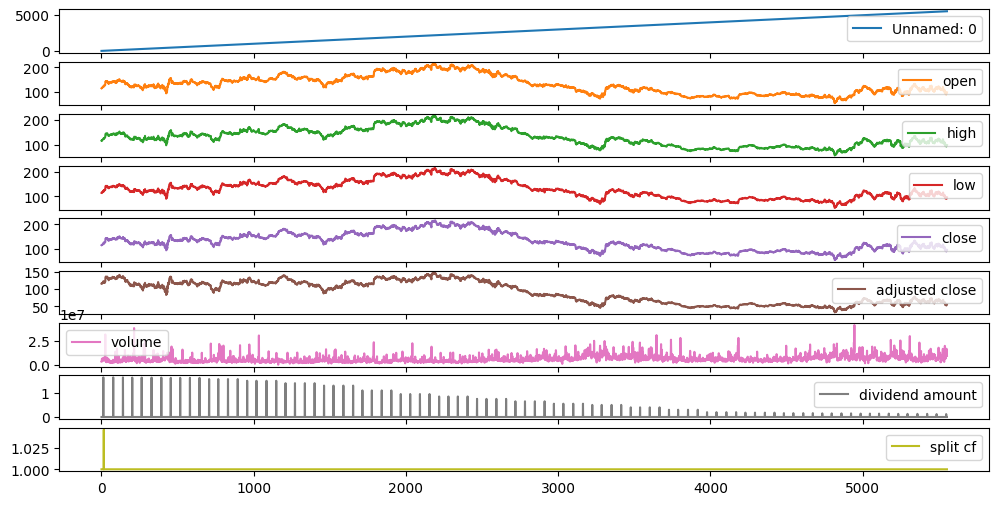

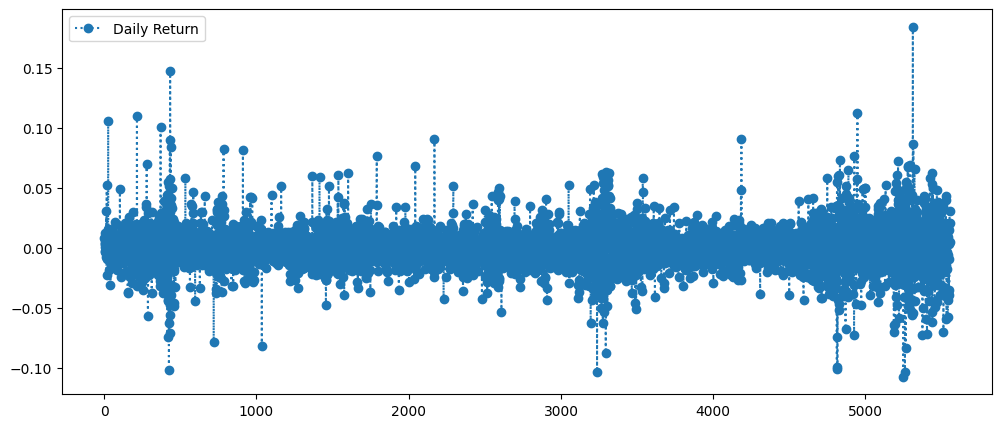

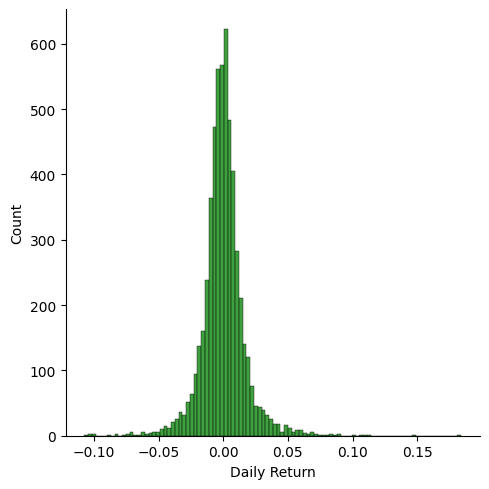

      Unnamed: 0    open     high     low   close  adjusted close    volume  \
0              0  115.00  116.335  114.56  115.81      115.810000   3322012   
1              1  116.16  117.270  116.08  116.73      116.730000   3220802   
2              2  116.79  117.940  116.04  116.79      116.790000   4914995   
3              3  116.00  118.810  115.19  116.47      116.470000   6417218   
4              4  116.49  116.560  115.27  116.05      116.050000   5384548   
...          ...     ...      ...     ...     ...             ...       ...   
5550        5550   92.75   92.940   90.19   90.25       52.226608  13737600   
5551        5551   94.44   94.440   90.00   91.56       52.984689  16697600   
5552        5552   95.87   95.940   93.50   94.37       54.610803  10369100   
5553        5553   96.75   96.810   93.69   94.81       54.865426  11105400   
5554        5554   98.50   98.810   96.37   96.75       55.988081   9551800   

      dividend amount  split cf        date  MA for

Unnamed: 0         0
open               0
high               0
low                0
close              0
adjusted close     0
volume             0
dividend amount    0
split cf           0
date               0
MA for 10 days     0
MA for 50 days     0
MA for 100 days    0
Daily Return       0
dtype: int64

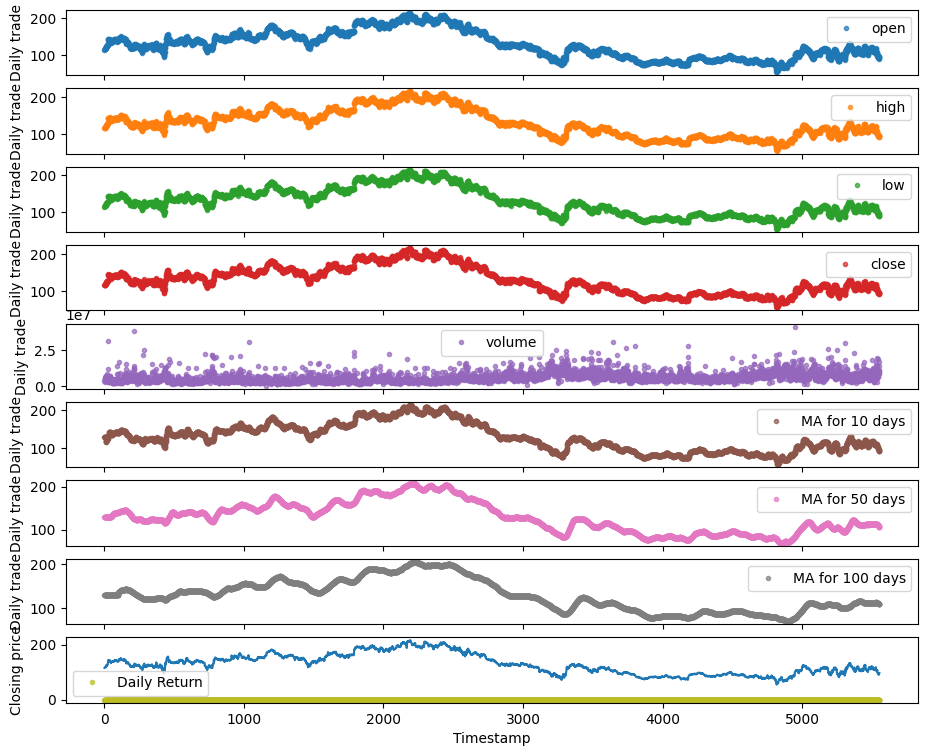

In [ ]:
trainData.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()
#data['Close'].plot(legend=True, figsize = (12, 6))
#plt.show()
#data['Volume'].plot(legend=True,figsize=(12,7))
#plt.show()

trainData.shape
trainData.size
trainData.describe(include='all').T
trainData.dtypes
trainData.nunique()
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    trainData[column_name] = trainData['close'].rolling(window=ma).mean()

trainData['Daily Return'] = trainData['close'].pct_change()
# plot the daily return percentage
trainData['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

sns.displot(trainData['Daily Return'].dropna(),bins=100,color='green')
plt.show()

date=pd.DataFrame(trainData['date'])
closing_df1 = pd.DataFrame(trainData['close'])
close1  = closing_df1.rename(columns={"close": "data_close"})
close2=pd.concat([date,close1],axis=1)
close2.head()

trainData.reset_index(drop=True, inplace=True)
# Identify numeric columns
numeric_cols = trainData.select_dtypes(include=[np.number]).columns

# Compute the mean only for numeric columns
means = trainData[numeric_cols].mean()

# Fill missing values in numeric columns only
trainData[numeric_cols] = trainData[numeric_cols].fillna(means)
trainData.head()

trainData.nunique()

trainData.sort_index(axis=1,ascending=True)

cols_plot = ['open', 'high', 'low','close','volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = trainData[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(trainData['close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = trainData
print(df)

trainData.isnull().sum()

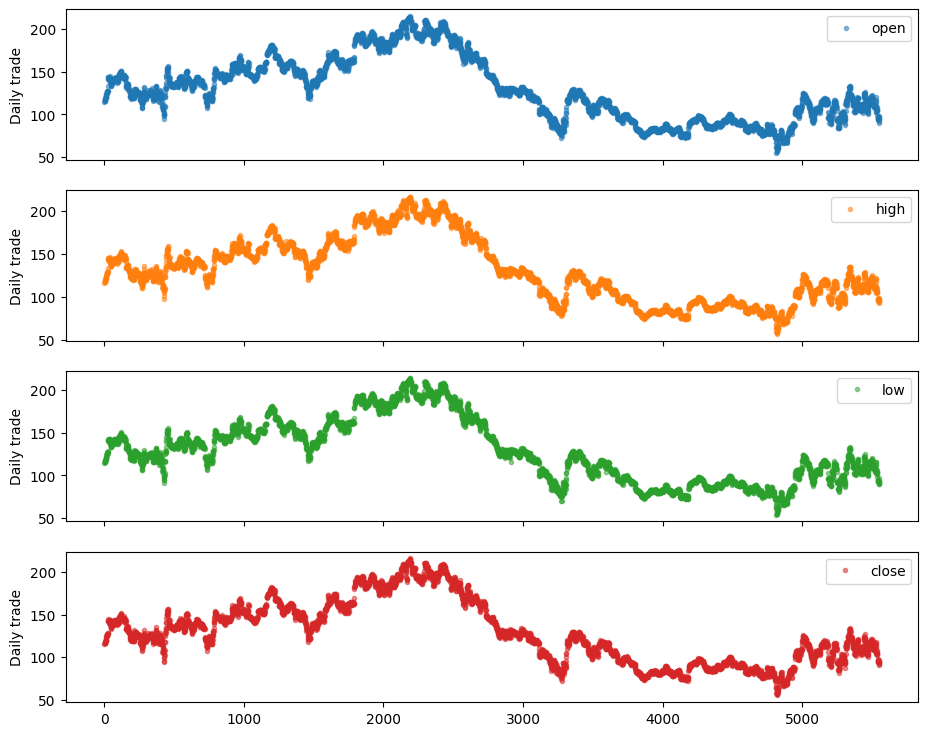

In [ ]:
cols_plot = ['open', 'high', 'low','close']
axes = trainData[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

      Unnamed: 0    open     high     low   close  adjusted close    volume  \
0              0  115.00  116.335  114.56  115.81      115.810000   3322012   
1              1  116.16  117.270  116.08  116.73      116.730000   3220802   
2              2  116.79  117.940  116.04  116.79      116.790000   4914995   
3              3  116.00  118.810  115.19  116.47      116.470000   6417218   
4              4  116.49  116.560  115.27  116.05      116.050000   5384548   
...          ...     ...      ...     ...     ...             ...       ...   
5550        5550   92.75   92.940   90.19   90.25       52.226608  13737600   
5551        5551   94.44   94.440   90.00   91.56       52.984689  16697600   
5552        5552   95.87   95.940   93.50   94.37       54.610803  10369100   
5553        5553   96.75   96.810   93.69   94.81       54.865426  11105400   
5554        5554   98.50   98.810   96.37   96.75       55.988081   9551800   

      dividend amount  split cf        date  MA for

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5555.0,2.777000e+03,1.603735e+03,0.000000,1.388500e+03,2.777000e+03,4.165500e+03,5.554000e+03
open,5555.0,1.292537e+02,3.676820e+01,54.650000,9.654500e+01,1.250800e+02,1.549250e+02,2.153800e+02
high,5555.0,1.304287e+02,3.682377e+01,56.700000,9.789000e+01,1.263900e+02,1.559600e+02,2.159000e+02
low,5555.0,1.281585e+02,3.671867e+01,54.010000,9.570500e+01,1.240300e+02,1.538050e+02,2.143000e+02
close,5555.0,1.293074e+02,3.677710e+01,55.070000,9.677000e+01,1.251000e+02,1.550500e+02,2.158000e+02
adjusted close,5555.0,9.018515e+01,3.182330e+01,32.383320,5.810611e+01,9.137930e+01,1.190654e+02,1.471306e+02
volume,5555.0,6.069019e+06,3.331583e+06,192843.000000,3.843918e+06,5.244594e+06,7.333746e+06,4.120730e+07
dividend amount,5555.0,1.247165e-02,1.207171e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.640000e+00
split cf,5555.0,1.000008e+00,6.171856e-04,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.046000e+00
MA for 10 days,5555.0,1.293462e+02,3.667733e+01,58.263000,9.700050e+01,1.252970e+02,1.549335e+02,2.131930e+02


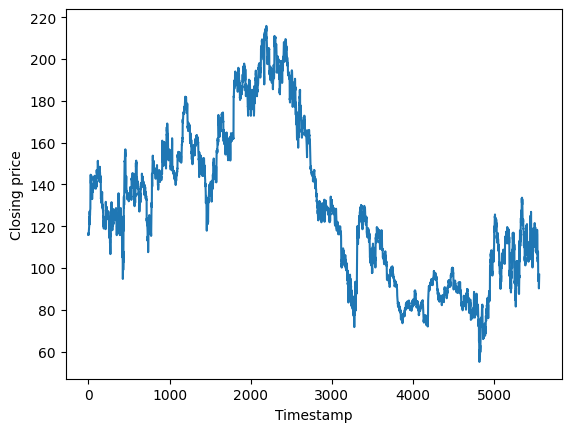

In [ ]:
plt.plot(trainData['close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = trainData
print(df)

df.describe().transpose()

In [ ]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    # ipdb.set_trace()
    first = df.iloc[i,1:5]
    # print (first)
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 1:5] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first[1]) / first[1])
    X.append(np.array(temp).reshape(100, 4))
    Y.append(np.array(temp2))

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, shuffle=False)

x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, shuffle=False)

train_X = np.array(x_train)
valid_X = np.array(x_valid)
train_Y = np.array(y_train)
valid_Y = np.array(y_valid)
test_X = np.array(x_test)
test_Y = np.array(y_test)

# Convert lists to uniform NumPy arrays if they aren't already
train_X = np.stack(train_X).astype(np.float32)
train_Y = np.stack(train_Y).astype(np.float32)
valid_X = np.stack(valid_X).astype(np.float32)
valid_Y = np.stack(valid_Y).astype(np.float32)
test_X = np.stack(test_X).astype(np.float32)
test_Y = np.stack(test_Y).astype(np.float32)

train_X = train_X.reshape(train_X.shape[0],100,4)
valid_X = valid_X.reshape(valid_X.shape[0],100,4)
test_X = test_X.reshape(test_X.shape[0],100,4)



In [ ]:
print(type(train_X))
print(train_X[0][1])
print(train_Y.shape)
print((valid_X.shape))
print((test_X.shape))

<class 'numpy.ndarray'>
[ 0.00542355  0.00571331 -0.00034459  0.00051401]
(3817, 1)
(1090, 100, 4)
(546, 100, 4)


### Dataloader Baseline



In [ ]:
# Assuming train_X, train_Y, test_X, test_Y are already loaded and converted to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_X), torch.tensor(train_Y))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(torch.tensor(valid_X), torch.tensor(valid_Y))
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(torch.tensor(test_X), torch.tensor(test_Y))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_X[0].shape

(100, 4)

## New Data

### Load Data

In [88]:
file_path = "/content/data/AAPL_sorted.csv"
data = pd.read_csv(file_path)

In [89]:
data.head()

,date,Open,High,Low,Close,Adj Close,Volume,sentiment.polarity_sum,sentiment.neg_sum,sentiment.neu_sum,sentiment.pos_sum,sentiment.polarity_avg,sentiment.neg_avg,sentiment.neu_avg,sentiment.pos_avg,sentiment.count
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clean Data

In [90]:
def clean_data(data):
  data['date'] = pd.to_datetime(data['date'])

  data = data[data['date'].dt.dayofweek < 5]

  req_data = data[['Open', 'High', 'Low', 'Close']]

  cleaned_data = req_data.dropna(subset=['Open', 'High', 'Low', 'Close'])

  # Ensure data is in proper type format
  cleaned_data = cleaned_data.copy()
  cleaned_data.loc[:, 'High'] = cleaned_data['High'].astype(float)
  cleaned_data.loc[:, 'Close'] = cleaned_data['Close'].astype(float)
  cleaned_data.loc[:, 'Open'] = cleaned_data['Open'].astype(float)
  # cleaned_data.loc[:, 'Volume'] = cleaned_data['Volume'].astype(float)
  cleaned_data.loc[:, 'Low'] = cleaned_data['Low'].astype(float)

  return cleaned_data

In [91]:
cleaned_data = clean_data(data)

In [92]:
print(cleaned_data.shape)
cleaned_data.head()

(10927, 4)


,Open,High,Low,Close
0,0.128348,0.128906,0.128348,0.128348
1,0.122210,0.122210,0.121652,0.121652
2,0.113281,0.113281,0.112723,0.112723
3,0.115513,0.116071,0.115513,0.115513
4,0.118862,0.119420,0.118862,0.118862


### Plot Data

In [93]:
def plot_data(data):
  data.plot(legend=True,subplots=True, figsize = (20, 20))
  plt.show()


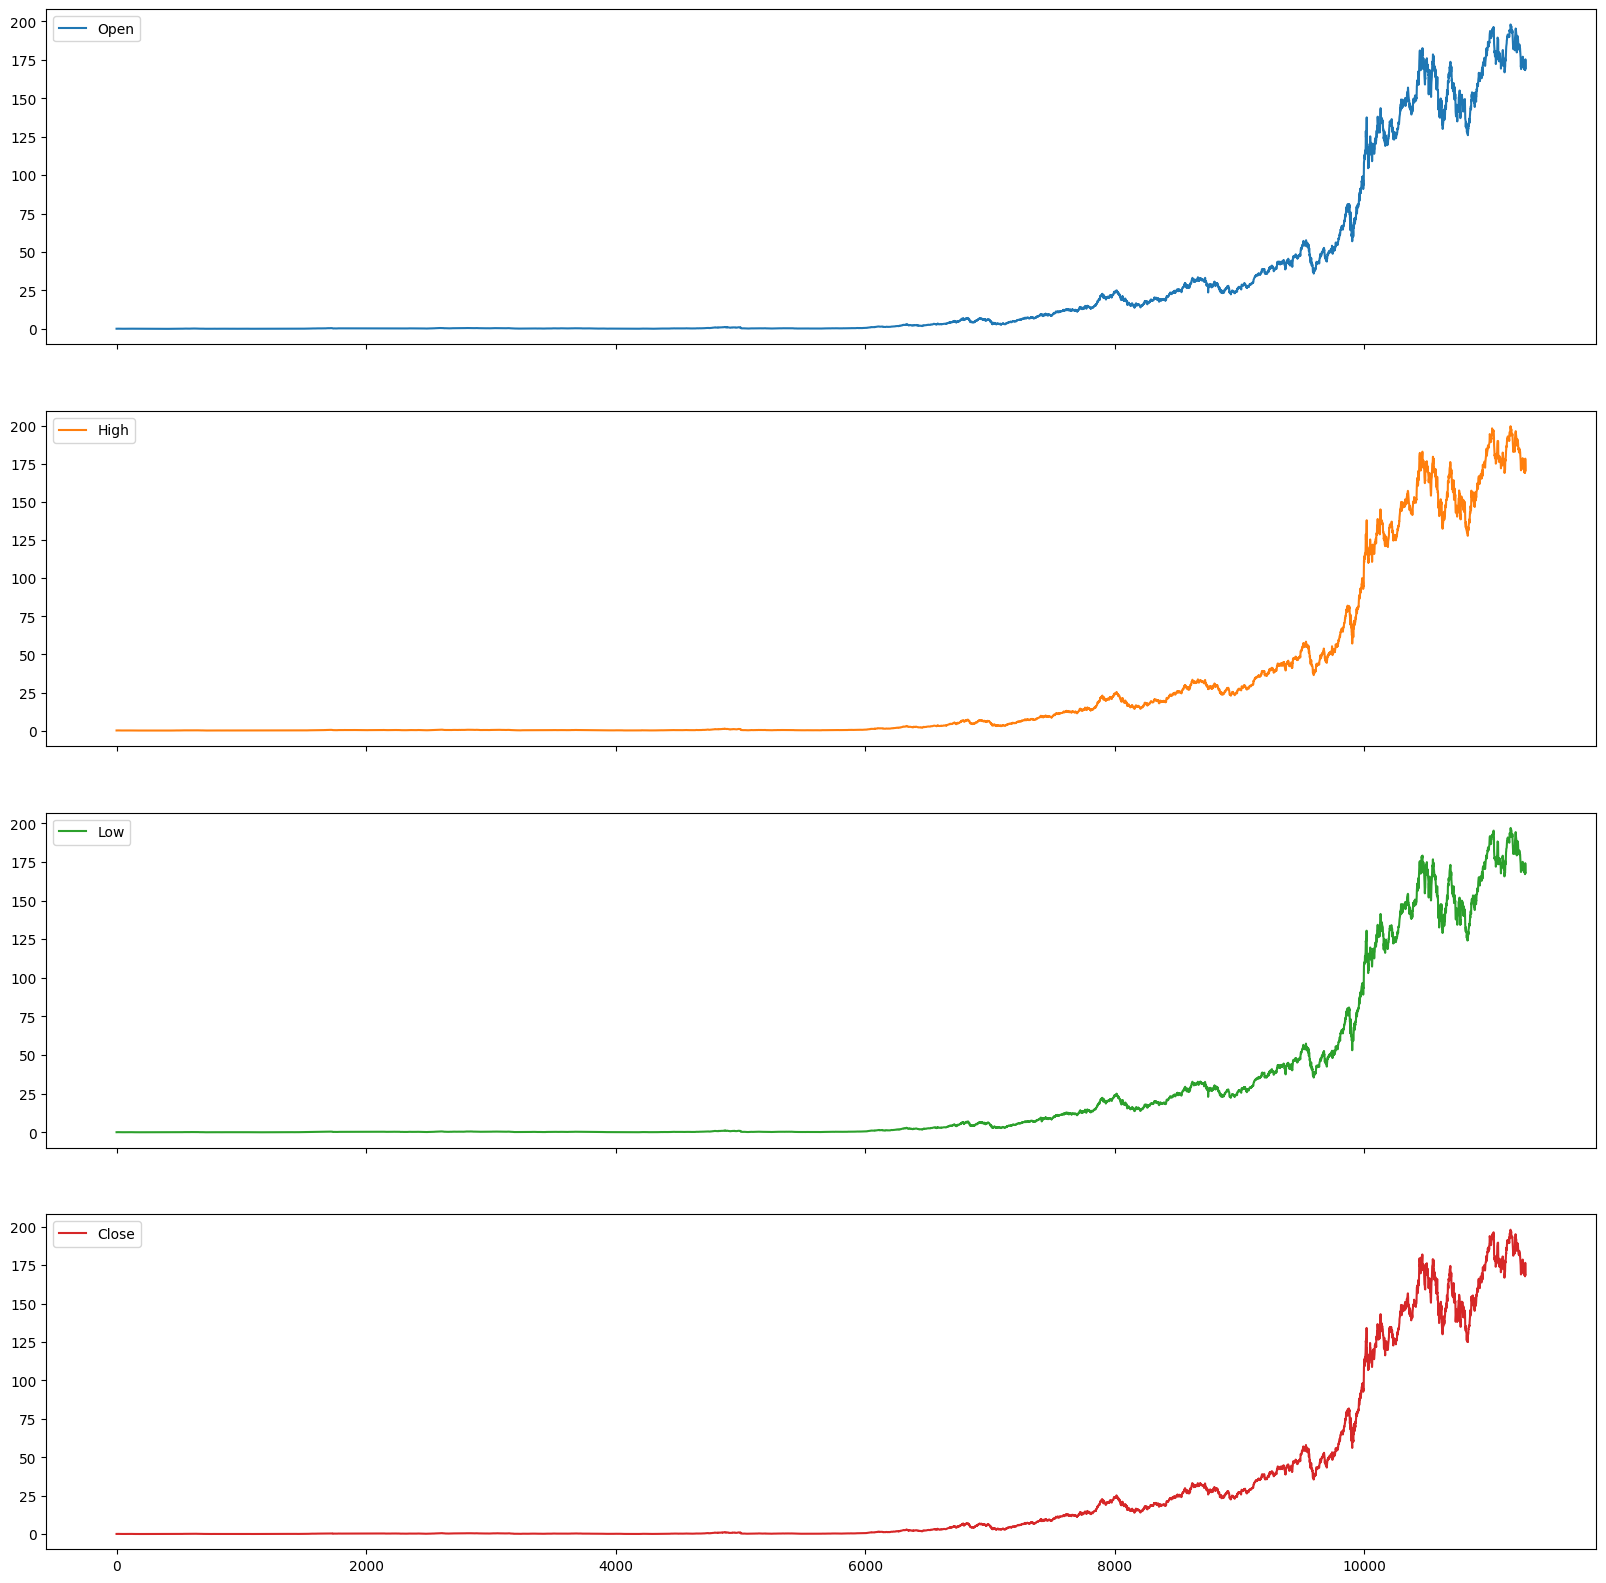

In [94]:
plot_data(cleaned_data)

### Prepare Data

In [95]:
def prepare_data_for_cnn_lstm_only(cleaned_data):

    df = cleaned_data
    X = []
    Y = []
    window_size = config['window_size']
    input_dim   = config['input_dim']

    for i in range(1 , len(df) - window_size -1 , 1):
        # ipdb.set_trace()
        first = df.iloc[i,0:4]
        # print (first)
        temp = []
        temp2 = []
        for j in range(window_size):
            temp.append((df.iloc[i + j, 0:input_dim] - first) / first)
        temp2.append((df.iloc[i + window_size, 3] - first[3]) / first[3])
        X.append(np.array(temp).reshape(window_size, input_dim))
        Y.append(np.array(temp2))

    x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, shuffle=False)

    x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, shuffle=False)

    train_X = np.array(x_train)
    valid_X = np.array(x_valid)
    train_Y = np.array(y_train)
    valid_Y = np.array(y_valid)
    test_X = np.array(x_test)
    test_Y = np.array(y_test)

    # Convert lists to uniform NumPy arrays if they aren't already
    train_X = np.stack(train_X).astype(np.float32)
    train_Y = np.stack(train_Y).astype(np.float32)
    valid_X = np.stack(valid_X).astype(np.float32)
    valid_Y = np.stack(valid_Y).astype(np.float32)
    test_X = np.stack(test_X).astype(np.float32)
    test_Y = np.stack(test_Y).astype(np.float32)

    train_X = train_X.reshape(train_X.shape[0],window_size,input_dim)
    valid_X = valid_X.reshape(valid_X.shape[0],window_size,input_dim)
    test_X = test_X.reshape(test_X.shape[0],window_size,input_dim)

    return train_X, train_Y, valid_X, valid_Y, test_X, test_Y


In [96]:
def prepare_data_for_cnn_lstm_transformer(cleaned_data):
    df = cleaned_data

    X = []
    Y = []
    shifted_X = [] # Shifted Closing Price for Decoder
    window_size = config['window_size']
    input_dim   = config['input_dim']

    for i in range(1 , len(df) - window_size -1 , 1):
    # for i in range(1 , 100 , 1):
        # ipdb.set_trace()
        first = df.iloc[i,0:4]
        # print (first)
        temp = []
        temp2 = []
        shifted_temp = []
        for j in range(window_size):
            temp.append((df.iloc[i + j, 0:input_dim] - first) / first)
            shifted_temp.append((df.iloc[i + j + 1, 3] - first[3]) / first[3])  # Next day's data as part of shifted sequence
        temp2.append((df.iloc[i + window_size, 3] - first[3]) / first[3])
        X.append(np.array(temp).reshape(window_size, input_dim))
        Y.append(np.array(temp2))
        shifted_X.append(np.array(shifted_temp)) # Shifted Closing Price for Decoder

    x_train, x_temp, y_train, y_temp, shifted_x_train, shifted_x_temp = train_test_split(X, Y, shifted_X, test_size=0.3, shuffle=False)
    # x_train, x_temp, shifted_x_train, y_train, y_temp, shifted_x_temp = train_test_split(X, Y, shifted_X, test_size=0.3, shuffle=False)

    x_valid, x_test, y_valid, y_test, shifted_x_valid, shifted_x_test = train_test_split(x_temp, y_temp, shifted_x_temp, test_size=0.3, shuffle=False)
    # x_valid, x_test, shifted_x_valid, y_valid, y_test, shifted_x_test = train_test_split(x_temp, y_temp, shifted_x_temp, test_size=1/3, shuffle=False)

    train_X = np.array(x_train)
    train_Y = np.array(y_train)
    valid_X = np.array(x_valid)
    valid_Y = np.array(y_valid)
    test_X = np.array(x_test)
    test_Y = np.array(y_test)

    # Shifted Closing Price for Decoder
    train_shifted_X = np.array(shifted_x_train)
    valid_shifted_X = np.array(shifted_x_valid)
    test_shifted_X = np.array(shifted_x_test)

    # Convert lists to uniform NumPy arrays if they aren't already
    train_X = np.stack(train_X).astype(np.float32)
    train_Y = np.stack(train_Y).astype(np.float32)
    valid_X = np.stack(valid_X).astype(np.float32)
    valid_Y = np.stack(valid_Y).astype(np.float32)
    test_X = np.stack(test_X).astype(np.float32)
    test_Y = np.stack(test_Y).astype(np.float32)

    # Shifted Closing Price for Decoder
    train_shifted_X = np.stack(train_shifted_X).astype(np.float32)
    valid_shifted_X = np.stack(valid_shifted_X).astype(np.float32)
    test_shifted_X = np.stack(test_shifted_X).astype(np.float32)

    train_X = train_X.reshape(train_X.shape[0],window_size,input_dim)
    valid_X = valid_X.reshape(valid_X.shape[0],window_size,input_dim)
    test_X = test_X.reshape(test_X.shape[0],window_size,input_dim)

    # Reshaping Shifted Closing Price for Decoder
    train_shifted_X = train_shifted_X.reshape(train_shifted_X.shape[0],window_size,1)
    valid_shifted_X = valid_shifted_X.reshape(valid_shifted_X.shape[0],window_size,1)
    test_shifted_X = test_shifted_X.reshape(test_shifted_X.shape[0],window_size,1)

    return train_X, train_Y, train_shifted_X, valid_X, valid_Y, valid_shifted_X, test_X, test_Y, test_shifted_X

In [97]:
train_shifted_X = None
valid_shifted_X = None
test_shifted_X  = None

if config['architecture'] == "cnn_lstm":
  train_X, train_Y, valid_X, valid_Y, test_X, test_Y = prepare_data_for_cnn_lstm_only(cleaned_data)
else:
  train_X, train_Y, train_shifted_X, valid_X, valid_Y, valid_shifted_X, test_X, test_Y, test_shifted_X = prepare_data_for_cnn_lstm_transformer(cleaned_data)

In [98]:
print(train_X[0][1])
print(train_X.shape)
print(train_Y.shape)
print((valid_X.shape))
print((test_X.shape))
if config['architecture'] != "cnn_lstm":
  print(train_shifted_X.shape)

[-0.07306276 -0.07306276 -0.07339789 -0.07339789]
(7577, 100, 4)
(7577, 1)
(2273, 100, 4)
(975, 100, 4)
(7577, 100, 1)


### Data Loader

In [99]:
def dataloader(train_X, train_Y, valid_X, valid_Y, test_X, test_Y, train_shifted_X=None, valid_shifted_X=None, test_shifted_X=None):

    if train_shifted_X is None:
        train_dataset = TensorDataset(torch.tensor(train_X), torch.tensor(train_Y))
    else:
        train_dataset = TensorDataset(torch.tensor(train_X), torch.tensor(train_Y), torch.tensor(train_shifted_X))
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

    if valid_shifted_X is None:
        val_dataset = TensorDataset(torch.tensor(valid_X), torch.tensor(valid_Y))
    else:
        val_dataset = TensorDataset(torch.tensor(valid_X), torch.tensor(valid_Y), torch.tensor(valid_shifted_X))
    valid_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

    if test_shifted_X is None:
        test_dataset = TensorDataset(torch.tensor(test_X), torch.tensor(test_Y))
    else:
        test_dataset = TensorDataset(torch.tensor(test_X), torch.tensor(test_Y), torch.tensor(test_shifted_X))
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    print(train_X.shape)
    print(train_Y.shape)
    # print(train_shifted_X.shape)
    print(train_X[0].shape)

    return train_loader, valid_loader, test_loader


In [100]:
train_loader, valid_loader, test_loader = dataloader(train_X, train_Y, valid_X, valid_Y, test_X, test_Y, train_shifted_X, valid_shifted_X, test_shifted_X)

(7577, 100, 4)
(7577, 1)
(100, 4)


##Sentiment-Data

In [7]:
file_path = "/content/data/combined_data_sentiment.csv"
combined_data = pd.read_csv(file_path)

In [8]:
combined_data.head()

,datetime,timestamp,gmtoffset,open,high,low,close,volume,date,sentiment.polarity,sentiment.neg,sentiment.neu,sentiment.pos
0,2020-10-12 13:30:00,1602509400,0,120.059997,120.410003,119.284500,120.239997,14777789.0,2020-10-12 11:52:03.000000000,-0.026,0.068,0.868,0.064
1,2020-10-12 13:35:00,1602509700,0,120.250000,121.000000,120.250000,120.762298,5450906.0,2020-10-12 11:52:03.000000000,-0.026,0.068,0.868,0.064
2,2020-10-12 13:40:00,1602510000,0,121.089996,121.362899,120.464996,120.534202,5741963.0,2020-10-12 11:52:03.000000000,-0.026,0.068,0.868,0.064
3,2020-10-12 13:45:00,1602510300,0,120.500000,120.699996,120.125000,120.140098,3940024.0,2020-10-12 11:52:03.000000000,-0.026,0.068,0.868,0.064
4,2020-10-12 13:50:00,1602510600,0,120.000000,120.220001,119.864997,120.119003,3583356.0,2020-10-12 11:52:03.000000000,-0.026,0.068,0.868,0.064


In [9]:
len(combined_data)

66168

In [10]:
req_data = combined_data[['open', 'high', 'low', 'close', 'volume', 'sentiment.polarity', 'sentiment.neg', 'sentiment.neu', 'sentiment.pos']]
req_data.shape

(66168, 9)

In [11]:
cleaned_data = req_data.dropna(subset=['open', 'high', 'low', 'close', 'volume', 'sentiment.polarity', 'sentiment.neg', 'sentiment.neu', 'sentiment.pos'])
cleaned_data.shape

(65443, 9)

In [12]:
cleaned_data.head()

,open,high,low,close,volume,sentiment.polarity,sentiment.neg,sentiment.neu,sentiment.pos
0,120.059997,120.410003,119.284500,120.239997,14777789.0,-0.026,0.068,0.868,0.064
1,120.250000,121.000000,120.250000,120.762298,5450906.0,-0.026,0.068,0.868,0.064
2,121.089996,121.362899,120.464996,120.534202,5741963.0,-0.026,0.068,0.868,0.064
3,120.500000,120.699996,120.125000,120.140098,3940024.0,-0.026,0.068,0.868,0.064
4,120.000000,120.220001,119.864997,120.119003,3583356.0,-0.026,0.068,0.868,0.064


In [13]:
# Ensure data is in proper type format
# Make a copy if cleaned_data is a slice from another DataFrame
cleaned_data = cleaned_data.copy()

cleaned_data.loc[:, 'open'] = cleaned_data['open'].astype(float)
cleaned_data.loc[:, 'high'] = cleaned_data['high'].astype(float)
cleaned_data.loc[:, 'low'] = cleaned_data['low'].astype(float)
cleaned_data.loc[:, 'close'] = cleaned_data['close'].astype(float)
cleaned_data.loc[:, 'volume'] = cleaned_data['volume'].astype(float)
cleaned_data.loc[:, 'sentiment.polarity'] = cleaned_data['sentiment.polarity'].astype(float)
cleaned_data.loc[:, 'sentiment.neg'] = cleaned_data['sentiment.neg'].astype(float)
cleaned_data.loc[:, 'sentiment.neu'] = cleaned_data['sentiment.neu'].astype(float)
cleaned_data.loc[:, 'sentiment.pos'] = cleaned_data['sentiment.pos'].astype(float)

In [14]:
print(cleaned_data.shape)
cleaned_data.head()

(65443, 9)


,open,high,low,close,volume,sentiment.polarity,sentiment.neg,sentiment.neu,sentiment.pos
0,120.059997,120.410003,119.284500,120.239997,14777789.0,-0.026,0.068,0.868,0.064
1,120.250000,121.000000,120.250000,120.762298,5450906.0,-0.026,0.068,0.868,0.064
2,121.089996,121.362899,120.464996,120.534202,5741963.0,-0.026,0.068,0.868,0.064
3,120.500000,120.699996,120.125000,120.140098,3940024.0,-0.026,0.068,0.868,0.064
4,120.000000,120.220001,119.864997,120.119003,3583356.0,-0.026,0.068,0.868,0.064


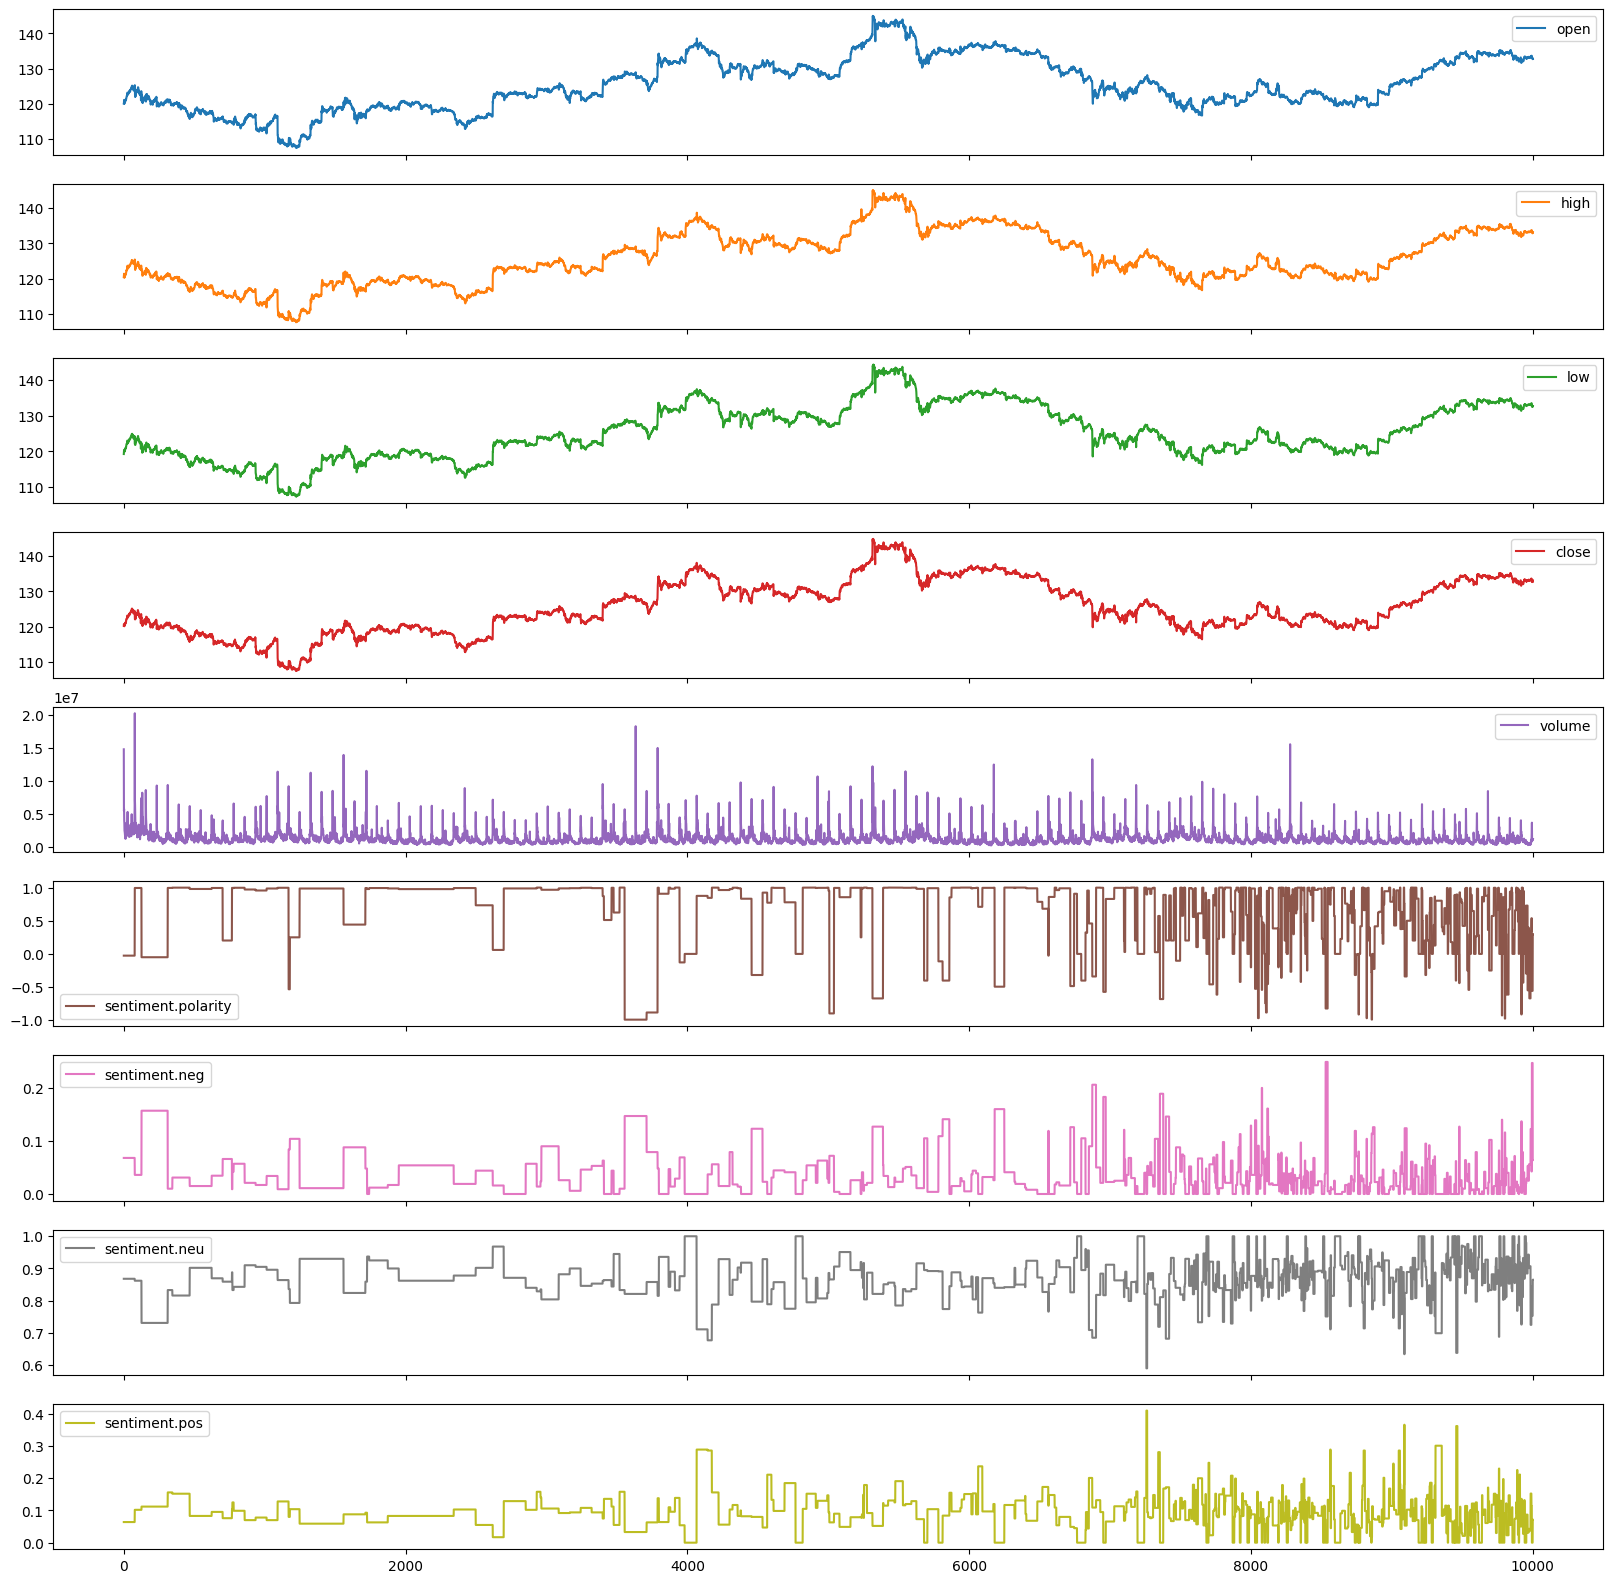

In [15]:
cleaned_data[0:10000].plot(legend=True,subplots=True, figsize = (20, 20))
plt.show()

In [16]:
df = cleaned_data[0:500]
has_nans = df.isnull().values.any()
print("Are there any NaN values in the DataFrame?", has_nans)
X = []
Y = []
shifted_X = [] # Shifted Closing Price for Decoder
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    # ipdb.set_trace()
    first = df.iloc[i,0:10]
    # print (first)
    temp = []
    temp2 = []
    shifted_temp = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 0:10] - first) / (first + 1e-10))
        shifted_temp.append((df.iloc[i + j + 1, 3] - first[3]) / (first[3] + 1e-10))  # Next day's data as part of shifted sequence
    temp2.append((df.iloc[i + window_size, 3] - first[3]) / (first[3] + 1e-10))
    X.append(np.array(temp).reshape(100, 9))
    Y.append(np.array(temp2))
    shifted_X.append(np.array(shifted_temp)) # Shifted Closing Price for Decoder


x_train, x_temp, y_train, y_temp, shifted_x_train, shifted_x_temp = train_test_split(X, Y, shifted_X, test_size=0.3, shuffle=False)
# x_train, x_temp, shifted_x_train, y_train, y_temp, shifted_x_temp = train_test_split(X, Y, shifted_X, test_size=0.3, shuffle=False)

x_valid, x_test, y_valid, y_test, shifted_x_valid, shifted_x_test = train_test_split(x_temp, y_temp, shifted_x_temp, test_size=0.3, shuffle=False)
# x_valid, x_test, shifted_x_valid, y_valid, y_test, shifted_x_test = train_test_split(x_temp, y_temp, shifted_x_temp, test_size=1/3, shuffle=False)

train_X = np.array(x_train)
has_nans = np.isnan(train_X).any()
print("Are there any NaN values in the array?", has_nans)

train_Y = np.array(y_train)
has_nans = np.isnan(train_Y).any()
print("Are there any NaN values in the array?", has_nans)

valid_X = np.array(x_valid)
has_nans = np.isnan(valid_X).any()
print("Are there any NaN values in the array?", has_nans)

valid_Y = np.array(y_valid)
has_nans = np.isnan(valid_Y).any()
print("Are there any NaN values in the array?", has_nans)

test_X = np.array(x_test)
has_nans = np.isnan(test_X).any()
print("Are there any NaN values in the array?", has_nans)

test_Y = np.array(y_test)
has_nans = np.isnan(test_Y).any()
print("Are there any NaN values in the array?", has_nans)

# Shifted Closing Price for Decoder
train_shifted_X = np.array(shifted_x_train)
valid_shifted_X = np.array(shifted_x_valid)
test_shifted_X = np.array(shifted_x_test)

# Convert lists to uniform NumPy arrays if they aren't already
train_X = np.stack(train_X).astype(np.float32)
train_Y = np.stack(train_Y).astype(np.float32)
valid_X = np.stack(valid_X).astype(np.float32)
valid_Y = np.stack(valid_Y).astype(np.float32)
test_X = np.stack(test_X).astype(np.float32)
test_Y = np.stack(test_Y).astype(np.float32)

# Shifted Closing Price for Decoder
train_shifted_X = np.stack(train_shifted_X).astype(np.float32)
valid_shifted_X = np.stack(valid_shifted_X).astype(np.float32)
test_shifted_X = np.stack(test_shifted_X).astype(np.float32)

train_X = train_X.reshape(train_X.shape[0],100,9)
valid_X = valid_X.reshape(valid_X.shape[0],100,9)
test_X = test_X.reshape(test_X.shape[0],100,9)

# Reshaping Shifted Closing Price for Decoder
train_shifted_X = train_shifted_X.reshape(train_shifted_X.shape[0],100,1)
valid_shifted_X = valid_shifted_X.reshape(valid_shifted_X.shape[0],100,1)
test_shifted_X = test_shifted_X.reshape(test_shifted_X.shape[0],100,1)

Are there any NaN values in the DataFrame? False
Are there any NaN values in the array? False
Are there any NaN values in the array? False
Are there any NaN values in the array? False
Are there any NaN values in the array? False
Are there any NaN values in the array? False
Are there any NaN values in the array? False


In [17]:
print(type(train_X))
print(train_X[0][1])
print(train_X.shape)
print(train_Y.shape)
print((valid_X.shape))
print((test_X.shape))

<class 'numpy.ndarray'>
[ 0.00698541  0.00299917  0.00178791 -0.0018888   0.05339608 -0.
  0.          0.          0.        ]
(278, 100, 9)
(278, 1)
(84, 100, 9)
(36, 100, 9)


In [18]:
train_dataset = TensorDataset(torch.tensor(train_X), torch.tensor(train_Y), torch.tensor(train_shifted_X))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(torch.tensor(valid_X), torch.tensor(valid_Y), torch.tensor(valid_shifted_X))
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(torch.tensor(test_X), torch.tensor(test_Y), torch.tensor(test_shifted_X))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(train_X.shape)
print(train_Y.shape)
print(train_shifted_X.shape)

(278, 100, 9)
(278, 1)
(278, 100, 1)


## To be fixed

### Normalize Data

In [ ]:
# ct = ColumnTransformer([
#     ('scale', StandardScaler(), ['Open', 'Close', 'High', 'Low']),  # Standard scaling for price data
#     ('norm', MinMaxScaler(), [ 'Volume'])  # Min-Max scaling for volume
# ], remainder='passthrough')
ct = MinMaxScaler(feature_range = (0, 1))
# ct = StandardScaler()

In [ ]:
normalized_data = ct.fit_transform(cleaned_data)
# ct.fit(cleaned_data)
# normalized_data = ct.transform(cleaned_data)

In [ ]:
# cleaned_data = cleaned_data.to_numpy(dtype=np.float64)
normalized_data.shape

(10927, 4)

### Test

In [ ]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    # ipdb.set_trace()
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, shuffle=False)

x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=1/3, shuffle=False)

train_X = np.array(x_train)
valid_X = np.array(x_valid)
train_Y = np.array(y_train)
valid_Y = np.array(y_valid)
test_X = np.array(x_test)
test_Y = np.array(y_test)

print((train_X.shape))
print((train_Y.shape))

train_X = train_X.reshape(train_X.shape[0],100,1)
valid_X = valid_X.reshape(valid_X.shape[0],100,1)
test_X = test_X.reshape(test_X.shape[0],100,1)
print((train_X.shape))
print((valid_X.shape))
print((test_X.shape))

### Split into Train, Validation, and Test

In [ ]:
train_data, leftover_data = train_test_split(normalized_data, test_size=0.2, random_state=42, shuffle=False)
validation_data, test_data = train_test_split(leftover_data, test_size=0.3, random_state=42, shuffle=False)

In [ ]:
train_data.shape

(8741, 4)

In [ ]:
train_data[8740]

array([0.14690501, 0.15006155, 0.14766825, 0.1508672 ])

In [ ]:
validation_data.shape

(1530, 4)

In [ ]:
validation_data[1529]

array([0.78254317, 0.787744  , 0.78365165, 0.7908724 ])

In [ ]:
test_data.shape

(656, 4)

In [ ]:
test_data[655]

array([0.85634211, 0.85478805, 0.85311063, 0.8524696 ])

### Dataset Class

In [ ]:
class StockDataset(Dataset):

  def __init__(self, inputs, sequence_length):
    self.data = inputs
    self.seq_length = sequence_length

    if config['sliding_window']:
      self.num_batches = len(self.data) - self.seq_length
    else:
      self.num_batches = len(self.data) // self.seq_length

  def __len__(self):
    return self.num_batches

  def __getitem__(self, index):

      if config['sliding_window']:
        start_idx = index
      else:
        start_idx = index * self.seq_length
      end_idx = start_idx + self.seq_length
      input = self.data[start_idx:end_idx, :]
      target = self.data[end_idx, 3]

      return torch.tensor(input, dtype=torch.float), torch.tensor(target, dtype=torch.float)


In [ ]:
class StockDatasetTest(Dataset):

  def __init__(self, inputs, sequence_length):
    self.data = inputs
    self.seq_length = sequence_length

    if config['sliding_window']:
      self.num_batches = len(self.data) - self.seq_length
    else:
      self.num_batches = len(self.data) // self.seq_length

  def __len__(self):
    return self.num_batches

  def __getitem__(self, index):

      if config['sliding_window']:
        start_idx = index
      else:
        start_idx = index * self.seq_length
      end_idx = start_idx + self.seq_length
      input = self.data[start_idx:end_idx, :]
      target = self.data[end_idx, 3]

      return torch.tensor(input, dtype=torch.float), torch.tensor(target, dtype=torch.float)


### Initialize Dataset

In [ ]:
train_dataset = StockDataset(train_data, sequence_length=100)
validation_dataset = StockDataset(validation_data, sequence_length=100)
test_dataset = StockDatasetTest(test_data, sequence_length=100)

### Dataloader New

In [ ]:
train_loader  = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True,
    drop_last   = True,
    num_workers = 2
)

In [ ]:
valid_loader  = DataLoader(
    dataset     = validation_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    drop_last   = True,
    num_workers = 2
)

In [ ]:
test_loader  = DataLoader(
    dataset     = test_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    drop_last   = True,
    num_workers = 2
)

In [ ]:
for i, data in enumerate(train_loader):
  inp, tr = data
  print ((inp.shape))
  # print (inp[0])
  print (tr.shape)
  print (tr[0])
  break

print (len(train_loader))
print (len(train_loader.dataset))

print (len(valid_loader))
print (len(valid_loader.dataset))

print (len(test_loader))
print (len(test_loader.dataset))

torch.Size([64, 100, 4])
torch.Size([64])
tensor(0.0045)
135
8641
22
1430
8
556


# Model Architecture

## Utilities

In [104]:
def create_mask_1(padded_input, input_lengths=None, pad_idx=None):
    """ Create a mask to identify non-padding positions.

    Args:
        padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
        input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
        pad_idx: Optional, the index used for padding tokens.

    Returns:
        A mask tensor with shape (N, T, 1), where non-padding positions are marked with 1 and padding positions are marked with 0.
    """

    assert input_lengths is not None or pad_idx is not None

    # Create a mask based on input_lengths
    if input_lengths is not None:
        N = padded_input.size(0)        # padded_input : (N x T x ...)
        non_pad_mask = padded_input.new_ones(padded_input.size()[:-1])  # (N x T)

        # Set the mask to 0 for padding positions
        for i in range(N):
          non_pad_mask[i, input_lengths[i]:] = 0

    if pad_idx is not None:             # padded_input : N x T

        assert padded_input.dim() == 2

        # Create a mask where non-padding positions are marked with 1 and padding positions are marked with 0
        non_pad_mask = padded_input.ne(pad_idx).float()

    return non_pad_mask.unsqueeze(-1)   # unsqueeze(-1) for broadcasting

In [105]:
def create_mask_2(seq, pad_idx=None):
    """ Create a mask to prevent positions from attending to subsequent positions.

    Args:
        seq: The input sequence tensor, shape (batch_size, sequence_length).

    Returns:
        A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
    """

    sz_b, len_s, _ = seq.size()

    # Create an upper triangular matrix with zeros on the diagonal and below (indicating allowed positions)
    #   and ones above the diagonal (indicating disallowed positions)
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)

    # Expand the mask to match the batch size, resulting in a mask for each sequence in the batch.
    mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls


    ''' Create a mask to ignore padding positions in the key sequence during attention calculation. '''

    # Expanding to fit the shape of key query attention matrix.
    if pad_idx != None:
      len_q = seq.size(1)

      # Create a mask where padding positions in the key sequence are marked with 1.
      padding_mask  = seq.eq(pad_idx)

      # Expand the mask to match the dimensions of the key-query attention matrix.
      padding_mask  = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk
      mask          = (padding_mask + mask).gt(0)

    else:
      mask = mask.gt(0)

    return mask

In [106]:
def create_mask_3(padded_input, input_lengths, expand_length):
    """ Create an attention mask to ignore padding positions in the input sequence during attention calculation.

    Args:
        padded_input: The input tensor with padding, shape (N, Ti, ...).
        input_lengths: The actual lengths of each sequence before padding, shape (N,).
        expand_length: The length to which the attention mask should be expanded,
            usually equal to the length of the sequence that the attention scores will be applied to.

    Returns:
        An attention mask tensor with shape (N, expand_length, Ti),
            where padding positions in the input sequence are marked with 1 and other positions are marked with 0.
    """

    # Create a mask to identify non-padding positions, shape (N, Ti, 1)
    # (N x Ti x 1)
    non_pad_mask    = create_mask_1(padded_input, input_lengths=input_lengths)
    # Invert the mask to identify padding positions, shape (N, Ti)
    # N x Ti, lt(1) like-not operation
    pad_mask        = non_pad_mask.squeeze(-1).lt(1)


    # Expand the mask to match the dimensions of the attention matrix, shape (N, expand_length, Ti)
    attn_mask       = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)

    return attn_mask

In [107]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature    = temperature                       # Scaling factor for the dot product
        self.dropout        = torch.nn.Dropout(attn_dropout)    # Dropout layer for attention weights
        self.softmax        = torch.nn.Softmax(dim=2)           # Softmax layer along the attention dimension

    def forward(self, q, k, v, mask=None):

        # Calculate the dot product between queries and keys.
        attn = torch.bmm(q, k.transpose(1, 2))

        # Scale the dot product by the temperature.
        attn = attn / self.temperature

        if mask is not None:
            # Apply the mask by setting masked positions to a large negative value.
            # This ensures they have a softmax score close to zero.
            mask_value = -1e+30 if attn.dtype == torch.float32 else -1e+4
            attn = attn.masked_fill(mask, mask_value)

        # Apply softmax to obtain attention weights.
        attn    = self.softmax(attn)

        # Apply dropout to the attention weights.
        attn    = self.dropout(attn)

        # Compute the weighted sum of values based on the attention weights.
        output  = torch.bmm(attn, v)

        return output, attn # Return the attention output and the attention weights.

In [108]:
def save_attention_plot(attention_weights, epoch=0):
    ''' function for saving attention weights plot to a file

        @NOTE: default starter code set to save cross attention
    '''

    plt.clf()  # Clear the current figure
    sns.heatmap(attention_weights, cmap="GnBu")  # Create heatmap

    # Save the plot to a file. Specify the directory if needed.
    plt.savefig(f"cross_attention-epoch{epoch}.png")

In [109]:
class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention Module '''

    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()

        self.n_head = n_head # Number of attention heads
        self.d_k    = d_model // n_head
        self.d_v    = d_model // n_head


        # Linear layers for projecting the input query, key, and value to multiple heads
        self.w_qs   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_ks   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_vs   = torch.nn.Linear(d_model, n_head * self.d_v)

        torch.nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_v)))

        # Initialize the weights of the linear layers
        self.attention = ScaledDotProductAttention(
            temperature=np.power(self.d_k, 0.5), attn_dropout=dropout)

        # Final linear layer to project the concatenated outputs of the attention heads back to the model dimension
        self.fc = torch.nn.Linear(n_head * self.d_v, d_model)

        torch.nn.init.xavier_normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        # following key, value, query standard computation
        # ipdb.set_trace()
        d_k, d_v, n_head    = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _       = q.size()
        sz_b, len_k, _       = k.size()
        sz_b, len_v, _     = v.size()

        # Project the input query, key, and value to multiple heads
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Rearrange the dimensions to group the heads together for parallel processing
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

        # Repeat the mask for each attention head if a mask is provided
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)

        # Apply scaled dot-product attention to the projected query, key, and value
        output, attn    = self.attention(q, k, v, mask=mask)

        # Rearrange the output back to the original order and concatenate the heads
        output          = output.view(n_head, sz_b, len_q, d_v)
        output          = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output          = self.dropout(self.fc(output))

        return output, attn

In [110]:
class PositionalEncoding(torch.nn.Module):
    ''' Position Encoding from Attention Is All You Need Paper '''

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Initialize a tensor to hold the positional encodings
        pe          = torch.zeros(max_len, d_model)

        # Create a tensor representing the positions (0 to max_len-1)
        position    = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine functions
        # This term creates a series of values that decrease geometrically, used to generate varying frequencies for positional encodings
        div_term    = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional encodings tensor and make it a buffer
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):

      return x + self.pe[:, :x.size(1)]

In [111]:
class FeedForward(torch.nn.Module):
    ''' Projection Layer (Fully Connected Layers) '''

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()

        self.linear_1   = torch.nn.Linear(d_model, d_ff)
        self.dropout    = torch.nn.Dropout(dropout)
        self.linear_2   = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):

        # Apply the first linear layer, GeLU activation, and then dropout
        x = self.dropout(torch.nn.functional.gelu(self.linear_1(x)))

         # Apply the second linear layer to project the dimension back to d_model
        x = self.linear_2(x)

        return x

In [112]:
# Utils for network
torch.cuda.empty_cache()

class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

## CNN-LSTM Encoder

In [113]:
class CNNBlock(torch.nn.Module):
    def __init__(self, cnn_in_channels, cnn_out_channels):
        super(CNNBlock, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=cnn_in_channels, out_channels=64, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)
        self.conv3 = torch.nn.Conv1d(in_channels=128, out_channels=cnn_out_channels, kernel_size=3, padding = 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):

        # ipdb.set_trace()

        x = self.conv1(x)

        x = self.relu(x)

        x = self.pool(x)

        x = self.conv2(x)

        x = self.relu(x)

        x = self.pool(x)

        x = self.conv3(x)

        x = self.relu(x)

        x = self.pool(x)

        return x


In [114]:
class CNN_LSTM_Encoder(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size, cnn_out_channels, dropout):
        super(CNN_LSTM_Encoder, self).__init__()
        self.cnn_block = CNNBlock(input_size, cnn_out_channels)
        self.lstm1 = torch.nn.LSTM(input_size = cnn_out_channels, hidden_size = encoder_hidden_size, batch_first=True, bidirectional=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.lstm2 = torch.nn.LSTM(input_size=2 * encoder_hidden_size, hidden_size=encoder_hidden_size, bidirectional=True, batch_first=True)
        self.final = torch.nn.Linear(2 * encoder_hidden_size, 1)

    def forward(self, x):

        # ipdb.set_trace()
        x = x.transpose(1, 2)
        # CNN part
        x = self.cnn_block(x)

        # LSTM part
        x = x.transpose(1, 2)

        x, _ = self.lstm1(x)

        x = self.dropout(x)

        x, _ = self.lstm2(x)

        x = self.dropout(x)

        return x

## Transformer Encoder

In [115]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha        = MultiHeadAttention(n_head=num_heads, d_model=d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model=d_model)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.dropout1   = torch.nn.Dropout(p=dropout)
        self.dropout2   = torch.nn.Dropout(p=dropout)

    def forward(self, inp):

        # Multi-Head Attention
        #   (1) perform Multi-Head Attention on inp

        attention_vector, attention_weights = self.mha(inp, inp, inp)

        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the input as a skip connection
        attention_vector_dropout = self.dropout1(attention_vector)
        attention_output = inp + attention_vector_dropout

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        attention_output_norm = self.layernorm1(attention_output)

        # Feed Forward Network
        #   (1) apply feed forward layer
        ff_output = self.ffn(attention_output_norm)

        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the output of the first layernorm as a skip connection
        ffn_output_dropout = self.dropout2(ff_output)
        encoder_output = ffn_output_dropout + attention_output_norm

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        encoder_output_norm = self.layernorm2(encoder_output)

        return encoder_output_norm

In [116]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, num_layers, d_model, num_heads, d_ff, dropout, enc_hidden_size, cnn_output_channels ):
        super(Encoder, self).__init__()


        self.embedding      = CNN_LSTM_Encoder(input_dim, enc_hidden_size, cnn_out_channels=cnn_output_channels, dropout=dropout)
        self.projection     = torch.nn.Linear(enc_hidden_size * 2, d_model)
        self.pos_encoding   = PositionalEncoding(d_model=d_model, max_len=100)

        # concatenating all num_layers EncoderLayer blocks
        self.enc_layers     = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.dropout        = torch.nn.Dropout(p=dropout)
        self.layernorm      = torch.nn.LayerNorm(d_model)

    def forward(self, x):

        # apply the CNN-LSTM Encoder (embedding)
        embedding_output = self.embedding(x)

        # adding projection layer to change dimension of encoder_outputs to match d_model
        linear_outputs = self.projection(embedding_output)

        # apply Positional Encoding on these extracted features
        pos_embeddings = self.pos_encoding(linear_outputs)

        # apply dropout as regularization technique
        encoder_outputs = self.dropout(pos_embeddings)

        # passing inputs through Transformer Encoder blocks
        for layer in self.enc_layers:
          encoder_outputs = layer(encoder_outputs)

        return encoder_outputs

## Transformer Decoder

In [117]:
class TransformerDecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(n_head=num_heads, d_model=d_model, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head=num_heads, d_model=d_model, dropout=dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout=dropout)

        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)

        self.dropout1 = torch.nn.Dropout(dropout)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.dropout3 = torch.nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        # Self-attention on the targets
        tgt2, _ = self.self_attn(tgt, tgt, tgt, mask=tgt_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)

        # Attention over the encoder's output
        tgt2, _ = self.enc_attn(tgt, memory, memory, mask=memory_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        # Feed forward network
        tgt2 = self.feed_forward(tgt)
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)

        return tgt

In [118]:
class TransformerDecoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout):
        super(TransformerDecoder, self).__init__()

        # Add a linear layer to project input dimension to d_model
        self.input_proj = torch.nn.Linear(1, d_model)
        self.pos_encoding   = PositionalEncoding(d_model=d_model, max_len=100)

        self.layers = torch.nn.ModuleList([TransformerDecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.linear = torch.nn.Linear(d_model, 1)  # Predicting one output at a time

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):

        # Projecting the input target dimension to match d_model
        tgt = self.input_proj(tgt)

        # apply Positional Encoding on these extracted features
        tgt = self.pos_encoding(tgt)

        # Creating the lookahead mask for the decoder using create_mask_2 function
        tgt_mask = create_mask_2(tgt)

        for layer in self.layers:
            tgt = layer(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask)
        return self.linear(tgt)  # Output shape (batch_size, seq_len, 1)

## Simple Decoder

In [119]:
class Decoder(torch.nn.Module):

    def __init__(self, input_size, output_size= 1):
        super().__init__()

        self.mlp = torch.nn.Sequential(

            torch.nn.Linear(input_size, input_size),
            PermuteBlock(),
            torch.nn.BatchNorm1d(input_size),
            PermuteBlock(),
            torch.nn.GELU(),
            torch.nn.Linear(input_size, input_size),
            PermuteBlock(),
            torch.nn.BatchNorm1d(input_size),
            PermuteBlock(),
            torch.nn.GELU(),
            torch.nn.Linear(input_size, output_size)
        )

    def forward(self, encoder_out):

        # ipdb.set_trace()
        out = self.mlp(encoder_out)

        return out

# Stock Predictor Architecture

In [120]:
# FullTransformerEncoder with TransformerDecoder

class StockPredictor(torch.nn.Module):
    def __init__(self, input_dim, enc_num_layers, dec_num_layers, enc_num_heads, dec_num_heads,
                 d_model, d_ff, dropout, lstm_hidden_size, cnn_output_channels):

        super(StockPredictor, self).__init__()

        if config['architecture'] == "cnn_lstm":
            self.encoder = CNN_LSTM_Encoder(input_dim, lstm_hidden_size, cnn_output_channels, dropout)
            self.decoder = Decoder(2 * lstm_hidden_size)
        elif config['architecture'] == "cnn_lstm_dec":
            self.encoder = CNN_LSTM_Encoder(input_dim, lstm_hidden_size, cnn_output_channels, dropout)
            self.decoder = TransformerDecoder(dec_num_layers, d_model, dec_num_heads, d_ff, dropout)
        else:
            self.decoder = TransformerDecoder(dec_num_layers, d_model, dec_num_heads, d_ff, dropout)
            self.encoder = Encoder(input_dim, enc_num_layers, d_model, enc_num_heads, d_ff,
                               dropout=dropout, enc_hidden_size=lstm_hidden_size, cnn_output_channels=cnn_output_channels)

    def forward(self, input, tgt=None):
        # passing through Encoder
        encoder_output = self.encoder(input)

        if config['architecture'] == "cnn_lstm":
            output = self.decoder(encoder_output)
        else:
            output = self.decoder(tgt, encoder_output)

        return output[:, -1, :]

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterance at a time """

        encoder_outputs, encoder_lens = self.encoder(inp, inp_len)
        out = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

# Model Setup

In [121]:
model =   StockPredictor(
input_dim                   = config['input_dim'],
enc_num_layers              = config['enc_num_layers'],
dec_num_layers              = config['dec_num_layers'],
enc_num_heads               = config['enc_num_heads'],
dec_num_heads               = config['dec_num_heads'],
lstm_hidden_size            = config['lstm_hidden_size'],
cnn_output_channels         = config['cnn_output'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

dropout                     = config['enc_dropout'])

# Model Summary

In [122]:
def custom_summary(model, input_size, target_size, device="cuda"):
    model = model.to(device)
    print("Layer Name \t Output Shape \t\t Params")
    print("="*50)

    input_tensor = torch.rand(input_size).to(device)

    if isinstance(target_size, tuple):
        target_tensor = torch.rand(target_size).to(device)
    else:
        target_tensor = torch.randint(low=0, high=target_size, size=(1,), dtype=torch.long).to(device)

    hooks = []
    summary = {}

    # Register a hook for each layer
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)
            key = f"{class_name}-{module_idx + 1}"

            if isinstance(output, tuple):
                output_shape = list(output[0].shape)
            else:
                output_shape = list(output.shape)
            # ipdb.set_trace()
            summary[key] = {
                "output_shape": output_shape,
                "params": sum([p.numel() for p in module.parameters()]),
            }

        if not module._modules:  # Register hook only if it is a leaf module
            hooks.append(module.register_forward_hook(hook))

    # Recursively visit all modules and register hooks
    model.apply(register_hook)
    # print(input_tensor.shape, target_tensor.shape)
    with torch.no_grad():
        model(input_tensor, target_tensor)  # Pass both dummy input and dummy target

    # Remove all hooks after the summary
    for h in hooks:
        h.remove()

    # Print the summary
    total_params = 0
    for layer in summary:
        print(f"{layer:20} {str(summary[layer]['output_shape']):20} {summary[layer]['params']}")
        total_params += summary[layer]['params']
    print("="*50)
    print(f"Total Params: {total_params}")


# Test Model

In [123]:
for i, data in enumerate(train_loader):
        inputs, targets, shifted_inputs = data
        inputs, targets, shifted_inputs = inputs.float().to(DEVICE), targets.float().to(DEVICE), shifted_inputs.float().to(DEVICE)

        targets = targets.reshape(targets.shape[0], -1)

        # print(inputs.shape, shifted_inputs.shape)
        custom_summary(model, inputs.shape, shifted_inputs.shape)

        # print(inputs.shape)
        outputs = model(inputs, shifted_inputs)


        # print(outputs.shape)
        # print(targets.shape)
        # print(shifted_inputs.shape)
        mse = mseLoss(outputs, targets)
        mae = maeLoss(outputs, targets)
        # print(mse)
        # print(mae)
        break

Layer Name 	 Output Shape 		 Params
Conv1d-1             [64, 64, 100]        832
ReLU-2               [64, 64, 100]        0
MaxPool1d-3          [64, 64, 50]         0
Conv1d-4             [64, 128, 50]        24704
ReLU-5               [64, 128, 50]        0
MaxPool1d-6          [64, 128, 25]        0
Conv1d-7             [64, 256, 25]        98560
ReLU-8               [64, 256, 25]        0
MaxPool1d-9          [64, 256, 12]        0
LSTM-10              [64, 12, 512]        1052672
Dropout-11           [64, 12, 512]        0
LSTM-12              [64, 12, 512]        1576960
Dropout-13           [64, 12, 512]        0
Linear-14            [64, 12, 512]        262656
PositionalEncoding-15 [64, 12, 512]        0
Dropout-16           [64, 12, 512]        0
Linear-17            [64, 12, 512]        262656
Linear-18            [64, 12, 512]        262656
Linear-19            [64, 12, 512]        262656
Softmax-20           [128, 12, 12]        0
Dropout-21           [128, 12, 12]       

In [124]:
for i, data in enumerate(train_loader):  # Assuming you have a DataLoader for your training data
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        # targets = targets.unsqueeze(1)
        targets = targets.reshape(targets.shape[0], -1)
        print(summary(model, inputs))
        # optimizer.zero_grad()
        print(inputs.shape)
        outputs = model(inputs)


        print(outputs.shape)
        print(targets.shape)
        mse = mseLoss(outputs, targets)
        mae = maeLoss(outputs, targets)
        print(mse)
        print(mae)
        break

ValueError: too many values to unpack (expected 2)

# Loss, Optimizer, Scheduler, Scaler

In [125]:
# Two loss functions defined for the model
mseLoss = torch.nn.MSELoss()

maeLoss = torch.nn.L1Loss()

optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.8, patience = 3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2, eta_min=0.000001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = 60, eta_min=1E-8)

# Mixed Precision, if you need it
scaler = torch.cuda.amp.GradScaler()

# WanDB

In [ ]:
USE_WANDB = True
RESUME_LOGGING = False

# creating your WandB run
run_name = f"newcode-arch-1-without-sentiments" # Ketan's run_name
# run_name = f"kmanimat-attempt-8-phase3WithSentiment" # Kiru's run name


if USE_WANDB:

    wandb.login(key="<YOUR WAND DB KEY>", relogin=True)

    if RESUME_LOGGING:
        run_id = ""
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "IDL-Project-Final",   ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "IDL-Project-Final",   ### Project should be created in our wandb account
            config  = config,        ### Wandb Config for our run
            entity="idlealites"
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        wandb.save("model_arch.txt")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ketanchaudhary010 (idlealites). Use `wandb login --relogin` to force relogin


In [ ]:
run.finish()

Predicted_Stock_Price,▂▃▃▃▃▃▃▃▃▂▂▃▄▆█▆▅▅▃▃▃▂▁▁▁▁▂▂▂▂▂▂▂▃▃▄▃▃▃▄
Real_Stock_Price,▂▃▃▃▄▄▃▃▃▂▂▃▄▆█▆▅▆▄▄▃▂▂▁▁▁▂▂▂▂▂▂▂▃▃▄▃▃▃▄
lr,████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
train_loss_mae,█▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_mse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss_mae,▇▇█▇▆▃▃▃▃▂▂▂▂▁▃▂▂▂▁▂▂▁▂▂▂▁▁▃▂▂▂▁▂▁▁▂▁▁▁▁
valid_loss_mse,▇▇█▇▅▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Predicted_Stock_Price,0.11886
Real_Stock_Price,0.11894
lr,0.00016
train_loss_mae,0.0245


# Training, Validation Modules

In [ ]:
def train_model_transformer(model, train_loader, mseLoss, maeLoss, optimizer):

    model.train()
    train_loss = 0.0
    total_mae = 0.0  # For Mean Absolute Error
    total_mse = 0.0  # For Mean Squared Error

    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)
    num_correct = 0

    for i, data in enumerate(train_loader):  # Assuming you have a DataLoader for your training data
        inputs, targets, shifted_inputs = data
        inputs, targets, shifted_inputs = inputs.float(), targets.float(), shifted_inputs.float()
        # targets = targets.unsqueeze(1)
        targets = targets.reshape(targets.shape[0], -1)

        optimizer.zero_grad()

        outputs = model(inputs, shifted_inputs)
        mse = mseLoss(outputs, targets)
        mae = maeLoss(outputs, targets)

        mse.backward()
        # mae.backward()
        optimizer.step()

        # train_loss += (mse.item() * inputs.size(0))
        # num_correct += int((torch.argmax(outputs, axis=1) == targets).sum())
        total_mse += float(mse.item() * inputs.size(0))  # Accumulate MSE; it's equivalent to the loss if using MSELoss
        total_mae += float(mae.item() * inputs.size(0))
        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_mse / (i + 1))),
            # acc= "{:.04f}%".format(100 * num_correct / (40 * (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar
    batch_bar.close() # Need this to close the tqdm bar

    # avg_loss = train_loss / len(train_loader.dataset)
    avg_mse = total_mse / len(train_loader.dataset)  # Average MSE over all samples
    avg_mae = total_mae / len(train_loader.dataset)
    # train_losses.append(avg_loss)

    return avg_mse, avg_mae

In [ ]:
def train_model(model, train_loader, mseLoss, maeLoss, optimizer):

    model.train()
    train_loss = 0.0
    total_mae = 0.0  # For Mean Absolute Error
    total_mse = 0.0  # For Mean Squared Error

    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)
    num_correct = 0

    for i, data in enumerate(train_loader):  # Assuming you have a DataLoader for your training data
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        # targets = targets.unsqueeze(1)
        targets = targets.reshape(targets.shape[0], -1)

        optimizer.zero_grad()

        outputs = model(inputs)
        mse = mseLoss(outputs, targets)
        mae = maeLoss(outputs, targets)

        mse.backward()
        # mae.backward()
        optimizer.step()

        # train_loss += (mse.item() * inputs.size(0))
        # num_correct += int((torch.argmax(outputs, axis=1) == targets).sum())
        total_mse += float(mse.item() * inputs.size(0))  # Accumulate MSE; it's equivalent to the loss if using MSELoss
        total_mae += float(mae.item() * inputs.size(0))
        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_mse / (i + 1))),
            # acc= "{:.04f}%".format(100 * num_correct / (40 * (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar
    batch_bar.close() # Need this to close the tqdm bar

    # avg_loss = train_loss / len(train_loader.dataset)
    avg_mse = total_mse / len(train_loader.dataset)  # Average MSE over all samples
    avg_mae = total_mae / len(train_loader.dataset)
    # train_losses.append(avg_loss)

    return avg_mse, avg_mae

In [ ]:
def validate_model_transformer(model, valid_loader, mseLoss, maeLoss):

    model.eval()  # Set model to evaluation mode

    batch_bar = tqdm(total=len(valid_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    total_loss = 0.0
    num_correct = 0
    total_mae = 0.0  # For Mean Absolute Error
    total_mse = 0.0  # For Mean Squared Error

    with torch.no_grad():  # No gradients needed for validation
        for inputs, targets, shifted_inputs in valid_loader:
            inputs, targets, shifted_inputs = inputs.float(), targets.float(), shifted_inputs.float()
            # targets = targets.unsqueeze(1)
            targets = targets.reshape(targets.shape[0], -1)

            outputs = model(inputs, shifted_inputs)
            loss = mseLoss(outputs, targets)
            mae = maeLoss(outputs, targets)

            # total_loss += float(loss.item() * inputs.size(0))
            total_mse += float(loss.item() * inputs.size(0))  # Accumulate MSE; it's equivalent to the loss if using MSELoss
            total_mae += float(mae.item() * inputs.size(0))
            # num_correct += int((torch.argmax(outputs, axis=1) == targets).sum())
            # val_loss += loss.item() * inputs.size(0)

            batch_bar.set_postfix(loss="{:.04f}".format(float(total_mse / (i + 1))))

            batch_bar.update()
    # val_loss /= len(valid_loader.dataset)

    # train_losses.append(train_loss)

    batch_bar.close()
    # avg_loss = total_loss/len(valid_loader.dataset)

    avg_mse = total_mse / len(valid_loader.dataset)  # Average MSE over all samples
    avg_mae = total_mae / len(valid_loader.dataset)
    # val_losses.append(total_loss)
    # acc = 100 * num_correct / (40 * len(valid_loader))
    return avg_mse, avg_mae


In [ ]:
def validate_model(model, valid_loader, mseLoss, maeLoss):

    model.eval()  # Set model to evaluation mode

    batch_bar = tqdm(total=len(valid_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    total_loss = 0.0
    num_correct = 0
    total_mae = 0.0  # For Mean Absolute Error
    total_mse = 0.0  # For Mean Squared Error

    with torch.no_grad():  # No gradients needed for validation
        for inputs, targets in valid_loader:
            inputs, targets = inputs.float(), targets.float()
            # targets = targets.unsqueeze(1)
            targets = targets.reshape(targets.shape[0], -1)

            outputs = model(inputs)
            loss = mseLoss(outputs, targets)
            mae = maeLoss(outputs, targets)

            # total_loss += float(loss.item() * inputs.size(0))
            total_mse += float(loss.item() * inputs.size(0))  # Accumulate MSE; it's equivalent to the loss if using MSELoss
            total_mae += float(mae.item() * inputs.size(0))
            # num_correct += int((torch.argmax(outputs, axis=1) == targets).sum())
            # val_loss += loss.item() * inputs.size(0)

            batch_bar.set_postfix(loss="{:.04f}".format(float(total_mse / (i + 1))))

            batch_bar.update()
    # val_loss /= len(valid_loader.dataset)

    # train_losses.append(train_loss)

    batch_bar.close()
    # avg_loss = total_loss/len(valid_loader.dataset)

    avg_mse = total_mse / len(valid_loader.dataset)  # Average MSE over all samples
    avg_mae = total_mae / len(valid_loader.dataset)
    # val_losses.append(total_loss)
    # acc = 100 * num_correct / (40 * len(valid_loader))
    return avg_mse, avg_mae


# Experiments

## Training and Validation

In [ ]:
for epoch in range(config['epochs']):
    print("\nEpoch: {}/{}".format(epoch + 1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    if config['architecture'] == "cnn_lstm":
        train_avg_mse, train_avg_mae = train_model(model, train_loader, mseLoss, maeLoss, optimizer)
        valid_avg_mse, valid_avg_mae  = validate_model(model, valid_loader, mseLoss, maeLoss)
    else:
        train_avg_mse, train_avg_mae = train_model_transformer(model, train_loader, mseLoss, maeLoss, optimizer)
        valid_avg_mse, valid_avg_mae  = validate_model_transformer(model, valid_loader, mseLoss, maeLoss)

    if config['scheduler'] == "ReduceLR":
        scheduler.step(train_avg_mse)
    else:
        scheduler.step()

    wandb.log({
        'train_loss_mse': train_avg_mse,
        'train_loss_mae': train_avg_mae,
        'valid_loss_mse': valid_avg_mse,
        'valid_loss_mae': valid_avg_mae,
        'lr'        : curr_lr
    })


    print("\tTrain Loss {:.07f}\t Train MSE {:.07f}\t Train MAE {:.07f}\t Learning Rate {:.07f}".format(train_avg_mse, train_avg_mse, train_avg_mae, curr_lr))
    print("Val Valid Loss {:.07f}\t Val MAE {:.07f}\t Val Loss {:.07f}".format(valid_avg_mse, valid_avg_mae, valid_avg_mse))
# run.finish()


Epoch: 1/50


	Train Loss 0.3231823	 Train MSE 0.3231823	 Train MAE 0.1932877	 Learning Rate 0.0020000
Val Valid Loss 0.0018663	 Val MAE 0.0345993	 Val Loss 0.0018663

Epoch: 2/50


	Train Loss 0.0076306	 Train MSE 0.0076306	 Train MAE 0.0648503	 Learning Rate 0.0019986
Val Valid Loss 0.0016184	 Val MAE 0.0341345	 Val Loss 0.0016184

Epoch: 3/50


	Train Loss 0.0048765	 Train MSE 0.0048765	 Train MAE 0.0518937	 Learning Rate 0.0019945
Val Valid Loss 0.0007389	 Val MAE 0.0216844	 Val Loss 0.0007389

Epoch: 4/50


	Train Loss 0.0037486	 Train MSE 0.0037486	 Train MAE 0.0451752	 Learning Rate 0.0019877
Val Valid Loss 0.0007682	 Val MAE 0.0214285	 Val Loss 0.0007682

Epoch: 5/50


	Train Loss 0.0031555	 Train MSE 0.0031555	 Train MAE 0.0409042	 Learning Rate 0.0019781
Val Valid Loss 0.0005903	 Val MAE 0.0189720	 Val Loss 0.0005903

Epoch: 6/50


	Train Loss 0.0036332	 Train MSE 0.0036332	 Train MAE 0.0440187	 Learning Rate 0.0019659
Val Valid Loss 0.0012526	 Val MAE 0.0279467	 Val Loss 0.0012526

Epoch: 7/50


	Train Loss 0.0027253	 Train MSE 0.0027253	 Train MAE 0.0379619	 Learning Rate 0.0019511
Val Valid Loss 0.0005936	 Val MAE 0.0188854	 Val Loss 0.0005936

Epoch: 8/50


	Train Loss 0.0027413	 Train MSE 0.0027413	 Train MAE 0.0380148	 Learning Rate 0.0019336
Val Valid Loss 0.0004128	 Val MAE 0.0153891	 Val Loss 0.0004128

Epoch: 9/50


	Train Loss 0.0024445	 Train MSE 0.0024445	 Train MAE 0.0358553	 Learning Rate 0.0019135
Val Valid Loss 0.0010275	 Val MAE 0.0256855	 Val Loss 0.0010275

Epoch: 10/50


	Train Loss 0.0023537	 Train MSE 0.0023537	 Train MAE 0.0354132	 Learning Rate 0.0018910
Val Valid Loss 0.0004918	 Val MAE 0.0172902	 Val Loss 0.0004918

Epoch: 11/50


	Train Loss 0.0021557	 Train MSE 0.0021557	 Train MAE 0.0335767	 Learning Rate 0.0018660
Val Valid Loss 0.0003744	 Val MAE 0.0145414	 Val Loss 0.0003744

Epoch: 12/50


	Train Loss 0.0023330	 Train MSE 0.0023330	 Train MAE 0.0346837	 Learning Rate 0.0018387
Val Valid Loss 0.0004797	 Val MAE 0.0172861	 Val Loss 0.0004797

Epoch: 13/50


	Train Loss 0.0032388	 Train MSE 0.0032388	 Train MAE 0.0411817	 Learning Rate 0.0018090
Val Valid Loss 0.0007422	 Val MAE 0.0226581	 Val Loss 0.0007422

Epoch: 14/50


	Train Loss 0.0027742	 Train MSE 0.0027742	 Train MAE 0.0379189	 Learning Rate 0.0017771
Val Valid Loss 0.0007486	 Val MAE 0.0223364	 Val Loss 0.0007486

Epoch: 15/50


	Train Loss 0.0022903	 Train MSE 0.0022903	 Train MAE 0.0345154	 Learning Rate 0.0017431
Val Valid Loss 0.0006131	 Val MAE 0.0200798	 Val Loss 0.0006131

Epoch: 16/50


	Train Loss 0.0020432	 Train MSE 0.0020432	 Train MAE 0.0327153	 Learning Rate 0.0017071
Val Valid Loss 0.0003357	 Val MAE 0.0134010	 Val Loss 0.0003357

Epoch: 17/50


	Train Loss 0.0020088	 Train MSE 0.0020088	 Train MAE 0.0329424	 Learning Rate 0.0016691
Val Valid Loss 0.0004112	 Val MAE 0.0153060	 Val Loss 0.0004112

Epoch: 18/50


	Train Loss 0.0021823	 Train MSE 0.0021823	 Train MAE 0.0340799	 Learning Rate 0.0016293
Val Valid Loss 0.0005004	 Val MAE 0.0173457	 Val Loss 0.0005004

Epoch: 19/50


	Train Loss 0.0023106	 Train MSE 0.0023106	 Train MAE 0.0347179	 Learning Rate 0.0015878
Val Valid Loss 0.0004359	 Val MAE 0.0157680	 Val Loss 0.0004359

Epoch: 20/50


	Train Loss 0.0023243	 Train MSE 0.0023243	 Train MAE 0.0353267	 Learning Rate 0.0015446
Val Valid Loss 0.0007410	 Val MAE 0.0227504	 Val Loss 0.0007410

Epoch: 21/50


	Train Loss 0.0023487	 Train MSE 0.0023487	 Train MAE 0.0346821	 Learning Rate 0.0015000
Val Valid Loss 0.0007423	 Val MAE 0.0218100	 Val Loss 0.0007423

Epoch: 22/50


	Train Loss 0.0019871	 Train MSE 0.0019871	 Train MAE 0.0322475	 Learning Rate 0.0014540
Val Valid Loss 0.0005308	 Val MAE 0.0179657	 Val Loss 0.0005308

Epoch: 23/50


	Train Loss 0.0020813	 Train MSE 0.0020813	 Train MAE 0.0328050	 Learning Rate 0.0014067
Val Valid Loss 0.0010062	 Val MAE 0.0262612	 Val Loss 0.0010062

Epoch: 24/50


	Train Loss 0.0019766	 Train MSE 0.0019766	 Train MAE 0.0316712	 Learning Rate 0.0013584
Val Valid Loss 0.0004158	 Val MAE 0.0151774	 Val Loss 0.0004158

Epoch: 25/50


	Train Loss 0.0019010	 Train MSE 0.0019010	 Train MAE 0.0313802	 Learning Rate 0.0013090
Val Valid Loss 0.0004151	 Val MAE 0.0155983	 Val Loss 0.0004151

Epoch: 26/50


	Train Loss 0.0018919	 Train MSE 0.0018919	 Train MAE 0.0316671	 Learning Rate 0.0012588
Val Valid Loss 0.0004734	 Val MAE 0.0166837	 Val Loss 0.0004734

Epoch: 27/50


	Train Loss 0.0018136	 Train MSE 0.0018136	 Train MAE 0.0304506	 Learning Rate 0.0012079
Val Valid Loss 0.0003965	 Val MAE 0.0151866	 Val Loss 0.0003965

Epoch: 28/50


	Train Loss 0.0017615	 Train MSE 0.0017615	 Train MAE 0.0301392	 Learning Rate 0.0011564
Val Valid Loss 0.0003383	 Val MAE 0.0135170	 Val Loss 0.0003383

Epoch: 29/50


	Train Loss 0.0016829	 Train MSE 0.0016829	 Train MAE 0.0297043	 Learning Rate 0.0011045
Val Valid Loss 0.0003623	 Val MAE 0.0141836	 Val Loss 0.0003623

Epoch: 30/50


	Train Loss 0.0017620	 Train MSE 0.0017620	 Train MAE 0.0304138	 Learning Rate 0.0010523
Val Valid Loss 0.0005997	 Val MAE 0.0198235	 Val Loss 0.0005997

Epoch: 31/50


	Train Loss 0.0016932	 Train MSE 0.0016932	 Train MAE 0.0297344	 Learning Rate 0.0010000
Val Valid Loss 0.0004538	 Val MAE 0.0165059	 Val Loss 0.0004538

Epoch: 32/50


	Train Loss 0.0017250	 Train MSE 0.0017250	 Train MAE 0.0298268	 Learning Rate 0.0009477
Val Valid Loss 0.0004832	 Val MAE 0.0172188	 Val Loss 0.0004832

Epoch: 33/50


	Train Loss 0.0016186	 Train MSE 0.0016186	 Train MAE 0.0288227	 Learning Rate 0.0008955
Val Valid Loss 0.0004995	 Val MAE 0.0171682	 Val Loss 0.0004995

Epoch: 34/50


	Train Loss 0.0016692	 Train MSE 0.0016692	 Train MAE 0.0294384	 Learning Rate 0.0008436
Val Valid Loss 0.0003420	 Val MAE 0.0134985	 Val Loss 0.0003420

Epoch: 35/50


	Train Loss 0.0017082	 Train MSE 0.0017082	 Train MAE 0.0295809	 Learning Rate 0.0007921
Val Valid Loss 0.0012246	 Val MAE 0.0301278	 Val Loss 0.0012246

Epoch: 36/50


	Train Loss 0.0016467	 Train MSE 0.0016467	 Train MAE 0.0288936	 Learning Rate 0.0007412
Val Valid Loss 0.0003752	 Val MAE 0.0145181	 Val Loss 0.0003752

Epoch: 37/50


	Train Loss 0.0017149	 Train MSE 0.0017149	 Train MAE 0.0296436	 Learning Rate 0.0006910
Val Valid Loss 0.0003547	 Val MAE 0.0139668	 Val Loss 0.0003547

Epoch: 38/50


	Train Loss 0.0016356	 Train MSE 0.0016356	 Train MAE 0.0287795	 Learning Rate 0.0006416
Val Valid Loss 0.0004442	 Val MAE 0.0161723	 Val Loss 0.0004442

Epoch: 39/50


	Train Loss 0.0015556	 Train MSE 0.0015556	 Train MAE 0.0280989	 Learning Rate 0.0005933
Val Valid Loss 0.0003282	 Val MAE 0.0133544	 Val Loss 0.0003282

Epoch: 40/50


	Train Loss 0.0014799	 Train MSE 0.0014799	 Train MAE 0.0276548	 Learning Rate 0.0005460
Val Valid Loss 0.0004794	 Val MAE 0.0167658	 Val Loss 0.0004794

Epoch: 41/50


	Train Loss 0.0015897	 Train MSE 0.0015897	 Train MAE 0.0286002	 Learning Rate 0.0005000
Val Valid Loss 0.0005164	 Val MAE 0.0179153	 Val Loss 0.0005164

Epoch: 42/50


	Train Loss 0.0015789	 Train MSE 0.0015789	 Train MAE 0.0282768	 Learning Rate 0.0004554
Val Valid Loss 0.0004476	 Val MAE 0.0165049	 Val Loss 0.0004476

Epoch: 43/50


	Train Loss 0.0014849	 Train MSE 0.0014849	 Train MAE 0.0276520	 Learning Rate 0.0004122
Val Valid Loss 0.0003794	 Val MAE 0.0146829	 Val Loss 0.0003794

Epoch: 44/50


	Train Loss 0.0015923	 Train MSE 0.0015923	 Train MAE 0.0284870	 Learning Rate 0.0003707
Val Valid Loss 0.0003607	 Val MAE 0.0140830	 Val Loss 0.0003607

Epoch: 45/50


	Train Loss 0.0014725	 Train MSE 0.0014725	 Train MAE 0.0273817	 Learning Rate 0.0003309
Val Valid Loss 0.0003376	 Val MAE 0.0136403	 Val Loss 0.0003376

Epoch: 46/50


	Train Loss 0.0015465	 Train MSE 0.0015465	 Train MAE 0.0279205	 Learning Rate 0.0002929
Val Valid Loss 0.0003362	 Val MAE 0.0135711	 Val Loss 0.0003362

Epoch: 47/50


	Train Loss 0.0014669	 Train MSE 0.0014669	 Train MAE 0.0271816	 Learning Rate 0.0002569
Val Valid Loss 0.0003398	 Val MAE 0.0136331	 Val Loss 0.0003398

Epoch: 48/50


	Train Loss 0.0014463	 Train MSE 0.0014463	 Train MAE 0.0269020	 Learning Rate 0.0002229
Val Valid Loss 0.0004064	 Val MAE 0.0154017	 Val Loss 0.0004064

Epoch: 49/50


	Train Loss 0.0014188	 Train MSE 0.0014188	 Train MAE 0.0264888	 Learning Rate 0.0001910
Val Valid Loss 0.0003476	 Val MAE 0.0137119	 Val Loss 0.0003476

Epoch: 50/50


	Train Loss 0.0013767	 Train MSE 0.0013767	 Train MAE 0.0262246	 Learning Rate 0.0001613
Val Valid Loss 0.0003315	 Val MAE 0.0134680	 Val Loss 0.0003315


## Save/Load Model to Wandb

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {"model_state_dict"         : model.state_dict(),
         "optimizer_state_dict"     : optimizer.state_dict(),
         "scheduler_state_dict"     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         "epoch"                    : epoch},
         path
    )

def load_model_from_wandb(model, artifact_path, file_path):

    # NEED TO CHANGE THE PROJECT NAME FROM WANDB ARTIFACTS FOLDER
    artifact = wandb.use_artifact(artifact_path, type='model')
    artifact_dir = artifact.download()

    # Extract the checkpoint file
    checkpoint_path = os.path.join(artifact_dir, file_path)

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])

    return model

In [ ]:
# Save epoch model
epoch_model_path = os.path.join(os.getcwd(), ('epoch' + str(epoch) + '.pth'))
save_model(model, optimizer, scheduler, ['train_avg_mse', train_avg_mse], epoch, epoch_model_path)
print("Saved epoch model")

# if best_loss >= train_loss:
#     best_loss = train_loss
#     save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
#     # wandb.save(best_loss_model_path)
#     print("Saved best training model")

Saved epoch model


In [ ]:
# Save latest epoch model to wandb using artifacts
model_artifact = wandb.Artifact('epoch_model', type='model')
model_artifact.add_file(epoch_model_path)
wandb.log_artifact(model_artifact)
print("Saved latest epoch model to wandb artifacts")

# Save best model to wandb using artifacts
# model_artifact = wandb.Artifact('best_loss_model', type='model')
# model_artifact.add_file(best_loss_model_path)
# wandb.log_artifact(model_artifact)
# print("Saved best model to wandb artifacts")

### Finish your wandb run
# run.finish()

Saved latest epoch model to wandb artifacts


In [ ]:
# Load model from wandb artifacts
model = load_model_from_wandb(model, artifact_path="kmanimat/IDL-Project-Final/epoch_model:v0", file_path="epoch21.pth")

wandb: Downloading large artifact epoch_model:v0, 190.85MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:4.3


## Testing

# Old Test

In [ ]:
def test_transformer_model(model, test_loader):

  model.eval()
  flatten = torch.nn.Flatten()
  batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  all_predicted = []
  all_labels = []
  # print (len(test1_X))
  results = []

  with torch.no_grad():  # No gradients needed for testing
        for inputs, labels, target in test_loader:
            # ipdb.set_trace()
            inputs, labels, target = inputs.float(), labels.float(), target.float()
            labels = labels.reshape(labels.shape[0], -1)
            outputs = model(inputs, target)
            # outputs = outputs[:, -1, :]
            outputs = outputs.reshape(outputs.shape[0], -1)
            # predicted = flatten(outputs)
            results.append(outputs)
            predicted = outputs.numpy().reshape(-1, 1)
            labels = labels.numpy().reshape(-1, 1)

            all_predicted.extend(predicted)
            all_labels.extend(labels)


            batch_bar.update()
  batch_bar.close()
  print(all_predicted)
  all_predicted = np.array(all_predicted)
  all_labels = np.array(all_labels)

  len_t = len(train_X) + len(valid_X)
  print(len_t)
  # ipdb.set_trace()
  for j in range(len_t, len_t + len(all_predicted)):
    # ipdb.set_trace()
    temp = cleaned_data.iloc[j, 3]  # Adjust this index based on your DataFrame
    all_labels[j - len_t] = all_labels[j - len_t] * temp + temp
    all_predicted[j - len_t] = all_predicted[j - len_t] * temp + temp
    wandb.log({
        'Real_Stock_Price': all_labels[j - len_t],
        'Predicted_Stock_Price': all_predicted[j - len_t]
    })

  # ipdb.set_trace()

  plt.plot(all_predicted, color='green', label='Predicted Stock Price')
  plt.plot(all_labels, color='red', label='Real Stock Price')
  plt.title('Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()

  plt.show()

  return results

In [ ]:
def test_model(model, test_loader):

  model.eval()
  flatten = torch.nn.Flatten()
  batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  all_predicted = []
  all_labels = []
  # print (len(test1_X))
  results = []

  with torch.no_grad():  # No gradients needed for testing
        for inputs, labels in test_loader:
            # ipdb.set_trace()
            inputs, labels = inputs.float(), labels.float()
            labels = labels.reshape(labels.shape[0], -1)
            outputs = model(inputs)
            # outputs = outputs[:, -1, :]
            outputs = outputs.reshape(outputs.shape[0], -1)
            # predicted = flatten(outputs)
            results.append(outputs)
            predicted = outputs.numpy().reshape(-1, 1)
            labels = labels.numpy().reshape(-1, 1)

            all_predicted.extend(predicted)
            all_labels.extend(labels)


            batch_bar.update()
  batch_bar.close()
  print(all_predicted)
  all_predicted = np.array(all_predicted)
  all_labels = np.array(all_labels)

  len_t = len(train_X) + len(valid_X)
  print(len_t)
  # ipdb.set_trace()
  for j in range(len_t, len_t + len(all_predicted)):
    # ipdb.set_trace()
    temp = cleaned_data.iloc[j, 3]  # Adjust this index based on your DataFrame
    all_labels[j - len_t] = all_labels[j - len_t] * temp + temp
    all_predicted[j - len_t] = all_predicted[j - len_t] * temp + temp
    wandb.log({
        'Real_Stock_Price': all_labels[j - len_t],
        'Predicted_Stock_Price': all_predicted[j - len_t]
    })

  print(all_labels)

  # ipdb.set_trace()

  plt.plot(all_predicted, color='green', label='Predicted Stock Price')
  plt.plot(all_labels, color='red', label='Real Stock Price')
  plt.title('Stock Price Prediction')
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend()

  plt.show()

  return results


[array([0.474264], dtype=float32), array([0.477997], dtype=float32), array([0.46144164], dtype=float32), array([0.43510345], dtype=float32), array([0.4693577], dtype=float32), array([0.5053593], dtype=float32), array([0.4237108], dtype=float32), array([0.4773422], dtype=float32), array([0.48595673], dtype=float32), array([0.47435373], dtype=float32), array([0.47836244], dtype=float32), array([0.47889233], dtype=float32), array([0.4977651], dtype=float32), array([0.47916144], dtype=float32), array([0.5411575], dtype=float32), array([0.536368], dtype=float32), array([0.56693363], dtype=float32), array([0.5493715], dtype=float32), array([0.5269035], dtype=float32), array([0.5347837], dtype=float32), array([0.5578613], dtype=float32), array([0.47662854], dtype=float32), array([0.49941474], dtype=float32), array([0.5284494], dtype=float32), array([0.513095], dtype=float32), array([0.4271607], dtype=float32), array([0.38660133], dtype=float32), array([0.4362229], dtype=float32), array([0.472

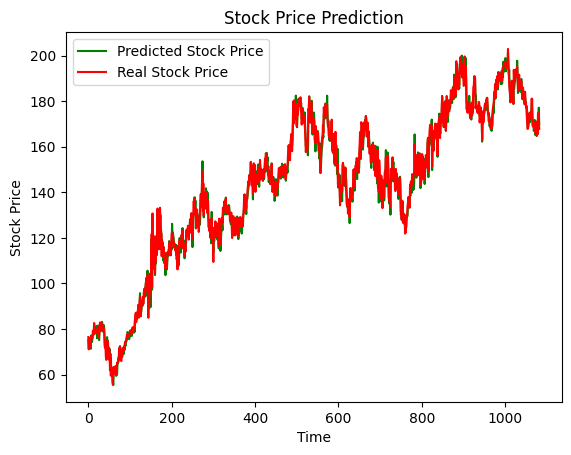

In [ ]:
if config['architecture'] == "cnn_lstm":
    results2 = test_model(model, test_loader)
else:
    results = test_transformer_model(model, test_loader)

In [ ]:
print(results1[0][1])
print(results2[0][1])

tensor([0.4780])
tensor([0.4780])


In [ ]:
run.finish()